<h1><center><font color=darkcyan>  Projet de fin d'Etudes MSA</font></center></h1>

<h2><center><font color=darkblue> Comparaison de méthodes à base d’inférence statistique et de machine learning pour le trading sur contrats futures. </font></center></h2>

<lu>
    <li><font color=darkblue> SOPGOUI MBEUKAM Lionel</font></li>
    <li><font color=darkblue> ADDASSI Youssef</font></li>
</lu>
<br/>
<font color=darkblue> Sous la supervision de Mr Laurent Abril. </font>
<hr>

<h1><center>Contenu</center></h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#introduction">Introduction</a></li>
        <li><a href="#partie1">Partie 1 - Etude statistique des données</a>
            <ul>
                <li><a href="#journee">Analyse statistique dans une journée</a></li>
                <li><a href="#meanvar">Moyenne et écart-type des returns en fonction de la période de la journée</a></li>
                <li><a href="#nuage">Nuages de points entre l'effort (composante volume) et le résultat (composante prix)</a></li>
                <li><a href="#correlation">Visualisation des matrices de corrélation entre les diffiérentes variables</a></li>
                <li><a href="#histogramme">Histogramme des volumes sur chaque période</a></li>
                <li><a href="#categorie">Catégories</a></li>
                <li><a href="#jeudi">La journée du Jeudi</a></li>
                <li><a href="#mardi">La journée du Mardi</a></li>
            </ul>
        </li>        
        <li><a href="#partie2">Partie 2 - Prédiction des prix (voire des volumes) futurs</a>
            <ul>
                <li><a href="#preparation">Préparation des données</a></li>
                <li><a href="#direction">Prédiction de la direction (+1/0/-1) à l'instant t+1 en fonction des variables à l'instant t</a></li>
                <li><a href="#knn">Algorithme des K Plus proches voisins (kNN)</a></li>
                <li><a href="#random">Forêts aléatoires</a></li>
                <li><a href="#ar">Prédiction de la courbe du prix à partir des autres variables : Par un modèle ARMA(p,q)</a></li>
                <li><a href="#lstm">Prédiction de la courbe du prix à partir des autres variables : Par un modèle LSTM</a></li>
                <li><a href="#garch">Par un modèle GARCH : Volume Filtered GARCH Model</a></li>
            </ul>
        </li> 
        <li><a href="#conclusion">Conclusion</a></li>
    </ul>
</div>
<br>
<hr>

<h2><center id="introduction"><font color=darkblue><u> Introduction </u></font></center></h2>

<font color=black>
<p>L’objectif du projet est d’analyser la relation effort/résultat entre les flux acheteurs et vendeurs (en temps réel) tels que fournis par les Bourses d’une part et les prix d’autre part afin de corréler cette relation aux tendances futures. Plus précisément ce projet a pour objectif d’analyser les composantes du volume (volume total d’échanges pendant une unité de temps donnée, volume acheteur/vendeur pendant cette même unité de temps), c’est-à-dire les composantes de l’effort pour essayer d’en prédire le résultat, c’est-à-dire la variation du prix compte tenu des caractéristiques de l’effort.</p>
<p>
L'ensemble de l'étude repose essentiellement les données marché du DAX de 2013 à 2019. Elle se fera en deux principales étapes, qui sont :
<ul>
    <li>Analyse statistique des données afin de trouver des relations, des informations qui pourront conduire à des choix d'investissements </li>
    <li>Utiliser les algorithmes pour prédire le prix / le return / la direction futurs de l'indice en fonction des informations connues dans le passé, et principalement le volume passé.</li>
</ul></p>
<p>Ce travail est réalisé entre octobre 2019 et janvier 2020, sous la supervision de Monsieur Laurent Abril, les réunions de deux heures étant organisées en général deux fois par mois.</p>
</font>
<hr/>

<h2><center id="partie1"><font color=darkblue><u>  Partie 1 - Etude statistique des données</u></font></center></h2>

### _Importation des bibliothèques_

In [1]:
import pandas as pd
import datetime
from sklearn.decomposition import PCA
import random
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from scipy import stats
import csv
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

<h3><center id="journee"><font color=darkblue> Analyse statistique dans une journée </font></center></h3>

### _Chargement des données_

In [2]:
data = pd.read_csv("DAX_STOXX/2019-10-16_DAX_1mn_BarData.txt", delimiter=',', skipinitialspace=True,
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)

### _A quoi ressemble notre DataFrame?_

In [3]:
data.head()

,Date,Time,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume
0,2013/1/4,08:00:00,7829.5,7832.0,7827.0,7828.5,343,5,2,3
1,2013/1/4,08:01:00,7828.0,7829.5,7827.5,7828.5,61,35,35,26
2,2013/1/4,08:02:00,7828.5,7830.0,7828.0,7829.0,27,19,10,17
3,2013/1/4,08:03:00,7829.0,7830.0,7828.0,7828.0,38,18,24,14
4,2013/1/4,08:04:00,7829.0,7829.5,7828.0,7828.0,15,12,7,8


### _Fusionner les dates et les heures, puis convertir en DateTime_

On fusionne les dates et les heures, puis, on les met en index des tables (dans le but de les utiliser comme des séries temporelles), puis on supprime les colonnnes times et DateTime (on garde Dates).

In [4]:
data['Datetime'] = pd.to_datetime(data['Date'] + ' '+ data['Time'])

In [5]:
data = data.set_index(pd.DatetimeIndex(data['Datetime']))
data = data.drop('Time', axis=1)
data = data.drop('Datetime', axis=1)

### _A quoi ressemble maintenant structure de données ?_

In [6]:
data.head()

,Date,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume
Datetime,,,,,,,,,
2013-01-04 08:00:00,2013/1/4,7829.5,7832.0,7827.0,7828.5,343,5,2,3
2013-01-04 08:01:00,2013/1/4,7828.0,7829.5,7827.5,7828.5,61,35,35,26
2013-01-04 08:02:00,2013/1/4,7828.5,7830.0,7828.0,7829.0,27,19,10,17
2013-01-04 08:03:00,2013/1/4,7829.0,7830.0,7828.0,7828.0,38,18,24,14
2013-01-04 08:04:00,2013/1/4,7829.0,7829.5,7828.0,7828.0,15,12,7,8


### _Fonctions pour découper les données en fonction des heures de Trading_

_L'objectif de cette fonction est de voir à quel niveau se situe le LAST par rapport au HIGH et au LOW._

In [7]:
def eval_pos(x, y, z):
    v = (x-y)/(x-z)
    for i in range(v.shape[0]):
        if v[i] <= 0.25:
            v[i] = -1
        elif v[i] > 0.75:
            v[i] = 1
        else:
            v[i] = 0
    return v

_L'objectif de cette fonction est de calculer les nouvelles variables à partir des anciennes_
<ul>
    <li>Le SPREAD est la différence entre le HIGH et le LOW de la période</li>
    <li>Le DELTA est la variation volume d'achat (Ask Volume) par rapport au volume des ventes (Bid Volume</li>
    <li>le NET RETURN est le profit réalisé sur la période.</li>
    <li>Le GROSS RETURN est le ratio de prix observé entre l'ouverture et la fermeture. </li>
    <li>L'IMBALANCE est le ratio du volume d'achat / de vente / ou le delta par rapport au volume total tradé sur la période.</li>
    <li>Le CLOSE POSITION PRICE est la position du LAST par rapport au High et au Low.</li>
</ul>

In [8]:
def complete_columns(data_):
    data_['Spread'] = data_['High'] - data_['Low'] 
    data_['Delta'] = data_['AskVolume'] - data_['BidVolume']
    data_['Net Return'] = (data_['Last'] - data_['Open']) / data_['Open']
    data_['Gross Return'] = (data_['Last'] - data_['Open'])
    data_['Imbalance Bid'] = (data_['BidVolume'] ) / (data_['Volume'] )
    data_['Imbalance Ask'] = (data_['AskVolume'] ) / (data_['Volume'] )
    data_['Imbalance'] = data_['Imbalance Ask'] - data_['Imbalance Bid']
    data_['Close Position Price'] = eval_pos(data_['Low'], data_['Last'], data_['High'])
    data_ = data_.drop('High', axis=1)
    data_ = data_.drop('Low', axis=1)
    data_ = data_.drop('Open', axis=1)
    data_ = data_.drop('NumberOfTrades', axis=1)
    return data_

_Fonction qui récupère tous les trades effectués à un intervalle de temps de la journée_

In [9]:
def slipt_data(data, deb, fin):
    data_ = data.between_time(deb, fin)
    data_ = data_.groupby(['Date']).agg({"High": "max", "Open" : "first",
                                            "Low": "min", "Last": "last", 
                                            "Volume": "sum", "BidVolume": "sum", 
                                            "AskVolume": "sum", "NumberOfTrades": "sum"})
    return data_

In [10]:
data_p = complete_columns(slipt_data(data, '08:00', '22:59'))
data_p.to_csv("daily_data_dax.csv")

<hr/>
<h3><center id="meanvar"><font color=darkblue> Moyenne et écart-type des returns en fonction de la période de la journée </font></center></h3>

### _Découper en heures de Trading, puis normaliser_

### _Les variables avec _ sont des variables normalisées_

In [10]:
mean = np.zeros([6, 12]) 
vol = np.zeros([6, 12])
period = np.array(['pre-open ue', 'morning ue', 'afternoon eu', 'pre-open us', 'close ue', 'close us'])

<font color=black> On constante deux éléments importants :
_On a 6 principales périades de trades dans une journée_
<ul>
    <li>Pré-ouverture du marché européen : 8h00 - 8h59</li>
    <li>Ouverture effective du marché européen (matinée) : 9h00 - 11h59</li>
    <li>Après-midi dans le marché européen : 12h00 - 14h29</li>
    <li>Pré-ouverture du marché américain : 14h30 - 15h29</li>
    <li>Pré-fermeture du marché européen (Ouverture effective du marché européen (matinée) ) : 15h30 - 17h30</li>
    <li>Pré-fermeture du marché européen : 17h31 - 22h03</li>
    </ul>
</font>

In [11]:
data_preopen_eu = complete_columns(slipt_data(data, '08:00', '08:59'))
mean[0] = data_preopen_eu.mean()
vol[0] = data_preopen_eu.std()
data_preopen_eu_ = (data_preopen_eu-data_preopen_eu.mean())/data_preopen_eu.std()

data_morning_eu = complete_columns(slipt_data(data, '09:00', '11:59'))
mean[1] = data_morning_eu.mean()
vol[1] = data_morning_eu.std()
data_morning_eu_ = (data_morning_eu-data_morning_eu.mean())/data_morning_eu.std()

data_afternoon_eu = complete_columns(slipt_data(data, '12:00', '14:30'))
mean[2] = data_afternoon_eu.mean()
vol[2] = data_afternoon_eu.std()
data_afternoon_eu_ = (data_afternoon_eu-data_afternoon_eu.mean())/data_afternoon_eu.std()

data_preopen_us = complete_columns(slipt_data(data, '14:31', '15:30'))
mean[3] = data_preopen_us.mean()
vol[3] = data_preopen_us.std()
data_preopen_us_ = (data_preopen_us-data_preopen_us.mean())/data_preopen_us.std()

data_close_eu = complete_columns(slipt_data(data, '15:31', '17:30'))
mean[4] = data_close_eu.mean()
vol[4] = data_close_eu.std()
data_close_eu_ = (data_close_eu-data_close_eu.mean())/data_close_eu.std()    

data_close_us = complete_columns(slipt_data(data, '17:31', '22:03'))
mean[5] = data_close_us.mean()
vol[5] = data_close_us.std()
data_close_us_ = (data_close_us-data_close_us.mean())/data_close_us.std()

### _A quoi ressemble les données d'une période ?_

In [12]:
data_close_us.tail()

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Date,,,,,,,,,,,,
2019/9/30,12414.5,13479,6712,6767,34.0,55,0.000121,1.5,0.497960,0.502040,0.004080,0.0
2019/9/4,12032.5,10008,5047,4961,38.0,-86,0.001832,22.0,0.504297,0.495703,-0.008593,1.0
2019/9/5,12114.5,9058,4458,4600,24.0,142,0.000372,4.5,0.492162,0.507838,0.015677,0.0
2019/9/6,12170.5,8950,4591,4359,28.0,-232,-0.000287,-3.5,0.512961,0.487039,-0.025922,0.0
2019/9/9,12215.0,10323,5219,5104,41.0,-115,0.000287,3.5,0.505570,0.494430,-0.011140,1.0


#### _On obtient les donnnées sur chaque période de la journée, ainsi que la moyenne et la volatilité des returns sur chaque période_

In [13]:
mean = np.transpose(mean)
vol = np.transpose(vol) 

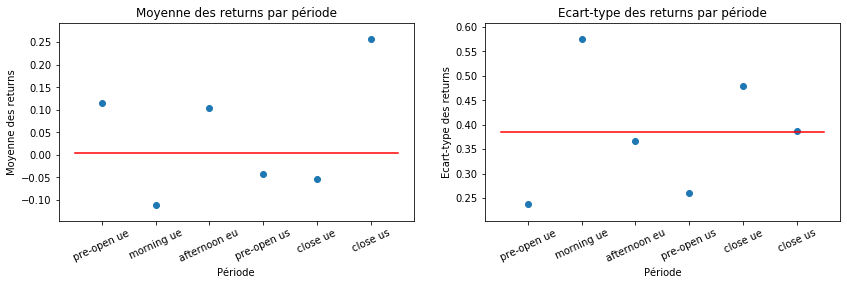

In [14]:
k = 6
plt.figure(1, figsize=(14,8))
plt.subplot(2, 2, 1)
plt.title('Moyenne des returns par période')
plt.xlabel('Période')
plt.ylabel('Moyenne des returns')
plt.scatter(period, 1000*mean[k,])
plt.plot([-0.5,5.5], [np.mean(100*mean[k,]),np.mean(100*mean[k,])], color='red')
plt.xticks(rotation=25)

plt.subplot(2, 2,2)
plt.title('Ecart-type des returns par période')
plt.xlabel('Période')
plt.ylabel('Ecart-type des returns')
plt.scatter(period, 100*vol[k,])
plt.plot([-0.5,5.5], [np.mean(100*vol[k,]),np.mean(100*vol[k,])], color='red')
plt.xticks(rotation=25)
plt.show()

<h3><center><font color=red>  Conclusion partielle 1 </font></center></h3>
<br/>
<font color=black>
L'idée de cette partie est de mesurer la moyenne et l'écart-type des returns sur les différentes périodes de trades dans une journée.<br/>
On constante deux éléments importants :
    <ol>
         <li>Pendant l'après midi aux Etats-Unis, c'est à dire entre 17h31 et 22h03 à Paris, <b>il peut être très intéressant de prendre des positions</b> car les returns moyens (en supposant qu'on est long sur l'actif), sont les plus élevés de la journée, et l'écart-type moyen est assez raisonable (dans la moyenne).</li>
        <li>En revanche, dans la matinée sur le marché européen, c'est à dire entre 9h30 et 11h59, <b>Il semble plus risqué de prendre des positions longues</b> car les returns moyens sont les plus faibles dans la journée, et en même temps l'écart-type est la plus grande.</li>
    </ol> 
</font>
<hr/>

<h3><center id="nuage"><font color=darkblue> Nuages de points entre l'effort (composante volume) et le résultat (composante prix) </font></center></h3>

_Fonction qui prend en entre l'effort  x et le résultat y, et affiche pour chaque période de la journée, le nuage de points entre x et y_

In [15]:
def plot_price_vol(y, x):
    plt.figure(1, figsize=(14,8))

    plt.subplot(3, 2, 1)
    plt.title('Pré-ouverture UE')
    plt.xlabel('Volume')
    plt.ylabel('Prix')
    plt.scatter(data_preopen_eu[x].values, data_preopen_eu[y].values)

    plt.subplot(3, 2,2)
    plt.title('Matinée UE')
    plt.xlabel('Volume')
    plt.ylabel('Prix')
    plt.scatter(data_morning_eu[x].values, data_morning_eu[y].values)

    plt.subplot(3, 2, 3)
    plt.title('Après-midi UE')
    plt.xlabel('Volume')
    plt.ylabel('Prix')
    plt.scatter(data_afternoon_eu[x].values, data_afternoon_eu[y].values)

    plt.subplot(3, 2,4)
    plt.title('Pré-ouverture US')
    plt.xlabel('Volume')
    plt.ylabel('Prix')
    plt.scatter(data_preopen_us[x].values, data_preopen_us[y].values)

    plt.subplot(3, 2, 5)
    plt.title('Soirée UE')
    plt.xlabel('Volume')
    plt.ylabel('Prix')
    plt.scatter(data_close_eu[x].values, data_close_eu[y].values)

    plt.subplot(3, 2,6)
    plt.title('Soirée US')
    plt.xlabel('Volume')
    plt.ylabel('Prix')
    plt.scatter(data_close_us[x].values, data_close_us[y].values)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

_Entre le prix à la fin d'une période et le volume trader sur la période_

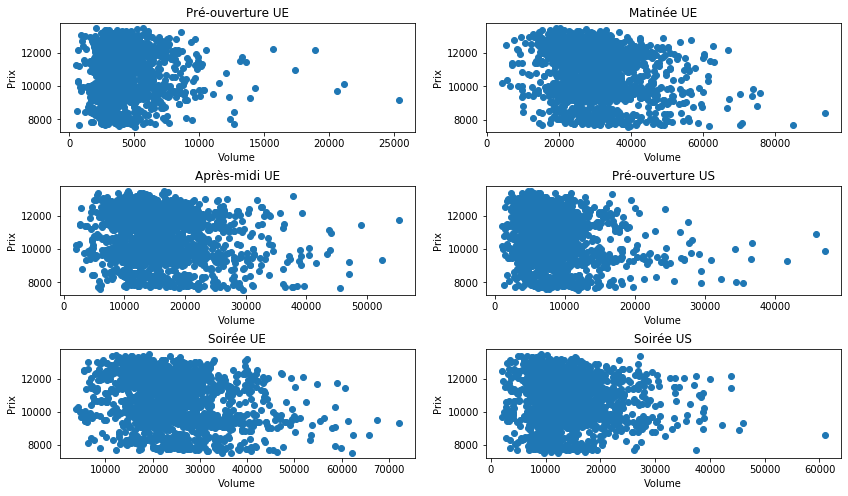

In [16]:
plot_price_vol("Last", "Volume")

_Entre le prix à la fin d'une période et le spread trader sur la période_

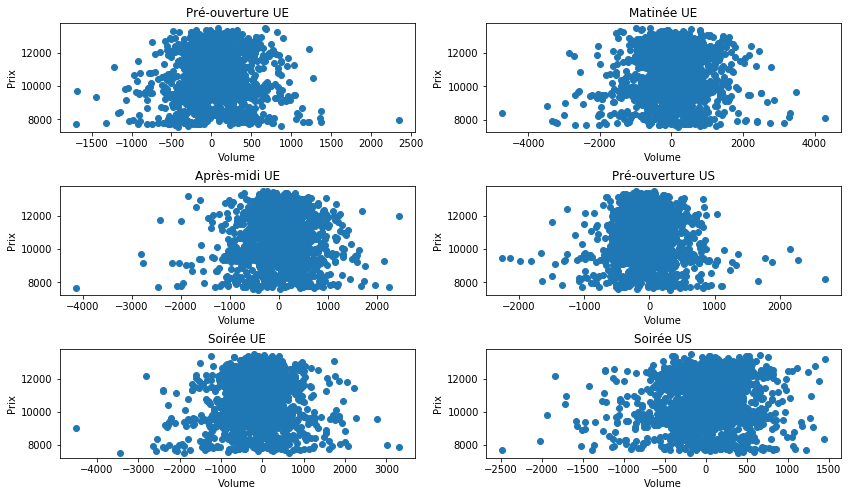

In [17]:
plot_price_vol("Last", 'Delta')

_Entre le Net Return à la fin d'une période et le volume tradé sur la période_

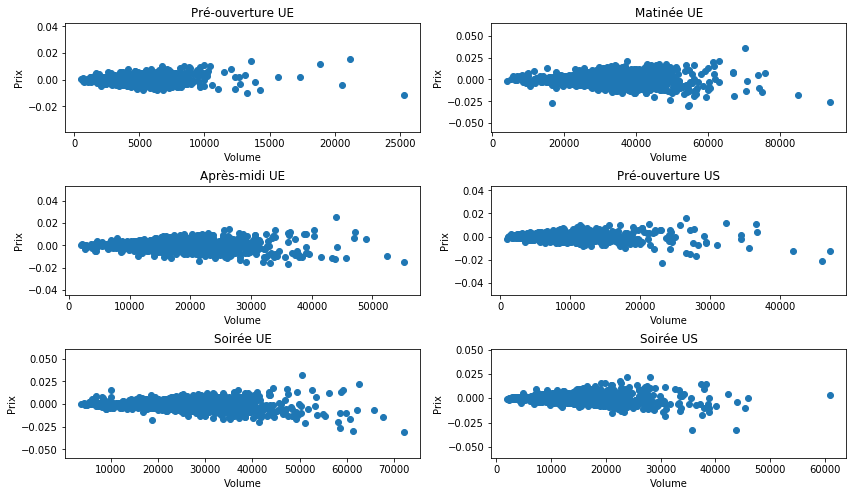

In [18]:
plot_price_vol("Net Return", "Volume")

_Entre le Net Return à la fin d'une période et le Delta tradé sur la période_

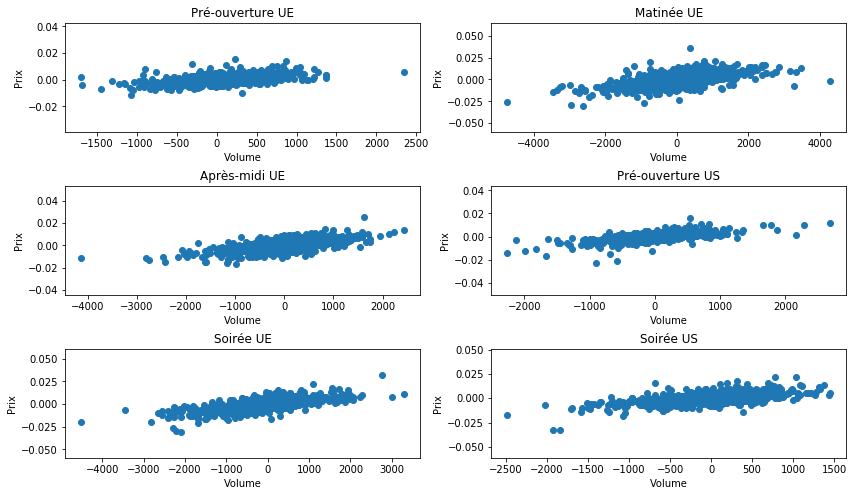

In [19]:
plot_price_vol("Net Return", 'Delta')

_Entre le Spread d'une période et le volume tradé sur la période_

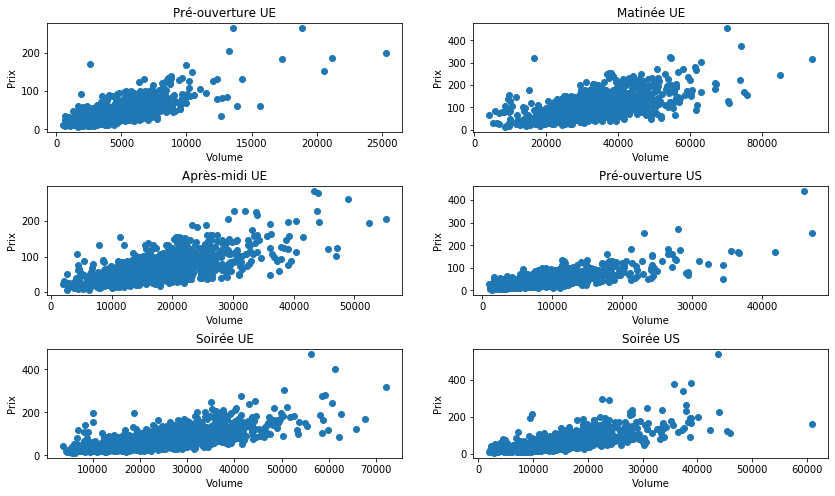

In [20]:
plot_price_vol("Spread", "Volume")

_Entre le Spread d'une période et le Delta tradé sur la période_

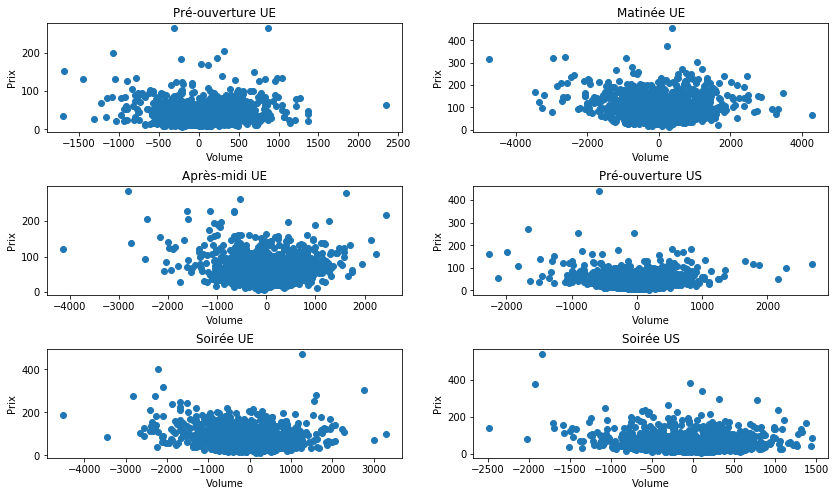

In [21]:
plot_price_vol("Spread", "Delta")

_Entre le Spread d'une période et l'imbalance Bid sur la période_

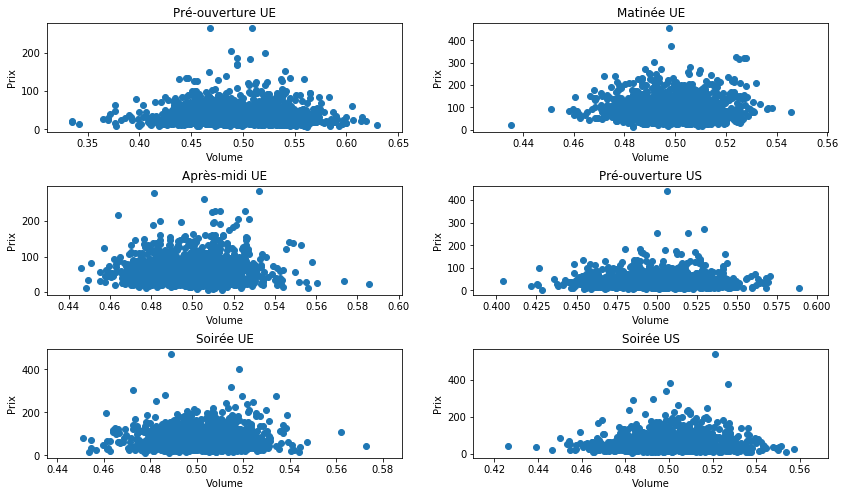

In [22]:
plot_price_vol("Spread", "Imbalance Bid")

_Entre le Spread d'une période et l'imbalance Ask sur la période_

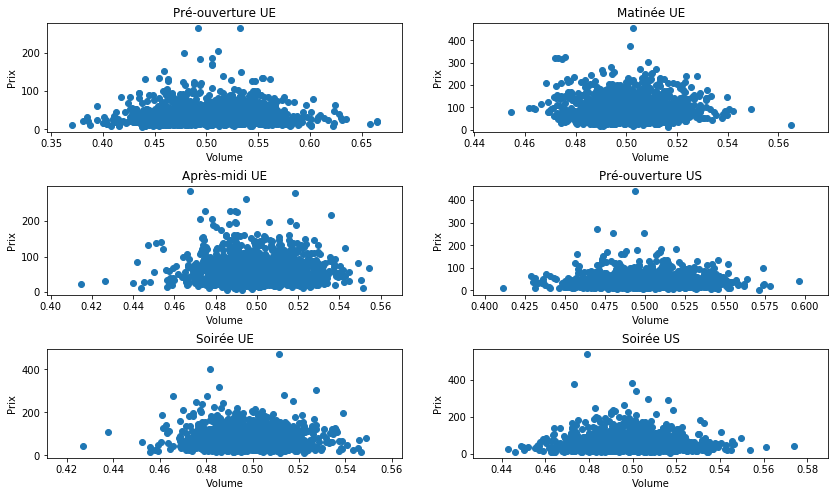

In [23]:
plot_price_vol("Spread", "Imbalance Ask")

_Entre le Spread d'une période et l'imbalance sur la période_

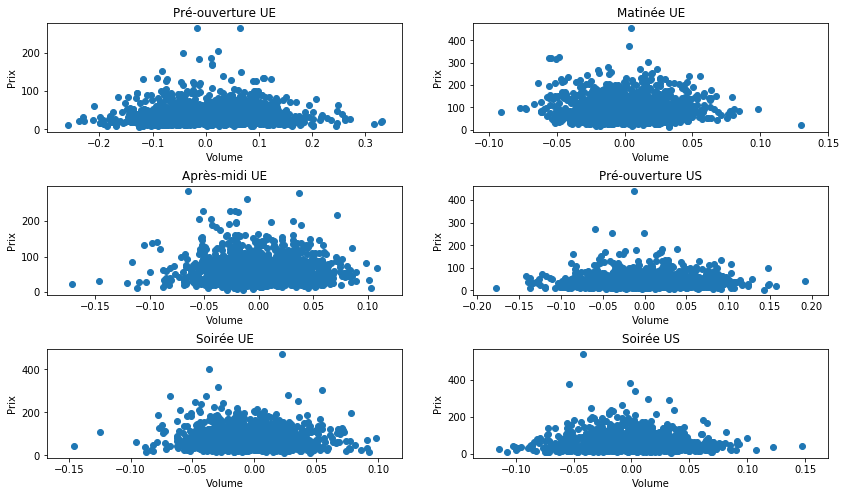

In [24]:
plot_price_vol("Spread", "Imbalance")

<h3><center><font color=red>  Conclusion partielle 2 </font></center></h3>
<font color=black> 
    Dans cette partie, l'objectif était d'afficher les différents nuages de points avec en abscisse la composante effort (volume, delta, ...) et en ordonnée la composante résutat (prix ou return), afin de voir s'il n y aurait pas une relation visuelle "triviale". 
<br/>    
On constante qu'à partir de ces graphes, aucune relation évidente ne se dessine entre les composantes prix et les composantes volumes. <br/>
Notons quand même une tendance linéaire entre le Net Return et le Delta. Peut-on en tirer des conclusions d'investissements? Pas encore. <br /><br />
ON DOIT POUSSER L'ANALYSE.
</font>
<hr/>

<h3><center id="correlation"><font color=darkblue> Visualisation des matrices de corrélation entre les diffiérentes variables </font></center></h3>

_Pré-ouverture du marché européen_

In [25]:
corr = round(data_preopen_eu.corr(), 3)
corr.style.background_gradient(cmap='coolwarm')

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Last,1,0.013,0.013,0.013,0.097,-0.001,-0.03,-0.023,0.024,-0.02,-0.022,-0.04
Volume,0.013,1,0.986,0.986,0.763,-0.016,0.168,0.172,0.008,-0.006,-0.007,0.094
BidVolume,0.013,0.986,1,0.943,0.746,-0.184,0.085,0.09,0.158,-0.156,-0.157,0.037
AskVolume,0.013,0.986,0.943,1,0.759,0.153,0.247,0.249,-0.144,0.145,0.144,0.148
Spread,0.097,0.763,0.746,0.759,1,0.027,0.241,0.243,-0.018,0.021,0.02,0.132
Delta,-0.001,-0.016,-0.184,0.153,0.027,1,0.479,0.47,-0.896,0.895,0.896,0.328
Net Return,-0.03,0.168,0.085,0.247,0.241,0.479,1,0.993,-0.38,0.379,0.379,0.657
Gross Return,-0.023,0.172,0.09,0.249,0.243,0.47,0.993,1,-0.376,0.375,0.376,0.658
Imbalance Bid,0.024,0.008,0.158,-0.144,-0.018,-0.896,-0.38,-0.376,1,-0.997,-0.999,-0.317
Imbalance Ask,-0.02,-0.006,-0.156,0.145,0.021,0.895,0.379,0.375,-0.997,1,0.999,0.316


_Ouverture effective du marché européen (matinée)_

In [26]:
corr = round(data_morning_eu.corr(), 3)
corr.style.background_gradient(cmap='coolwarm')

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Last,1,-0.225,-0.226,-0.222,0.043,0.046,0.031,0.026,-0.047,0.047,0.047,0.004
Volume,-0.225,1,0.997,0.997,0.666,-0.082,-0.085,-0.081,0.067,-0.067,-0.067,-0.015
BidVolume,-0.226,0.997,1,0.988,0.664,-0.158,-0.13,-0.124,0.139,-0.139,-0.139,-0.051
AskVolume,-0.222,0.997,0.988,1,0.664,-0.004,-0.04,-0.037,-0.006,0.006,0.006,0.022
Spread,0.043,0.666,0.664,0.664,1,-0.055,-0.044,-0.045,0.029,-0.029,-0.029,-0.011
Delta,0.046,-0.082,-0.158,-0.004,-0.055,1,0.583,0.566,-0.937,0.937,0.937,0.475
Net Return,0.031,-0.085,-0.13,-0.04,-0.044,0.583,1,0.992,-0.513,0.513,0.513,0.703
Gross Return,0.026,-0.081,-0.124,-0.037,-0.045,0.566,0.992,1,-0.506,0.506,0.506,0.709
Imbalance Bid,-0.047,0.067,0.139,-0.006,0.029,-0.937,-0.513,-0.506,1,-1,-1,-0.476
Imbalance Ask,0.047,-0.067,-0.139,0.006,-0.029,0.937,0.513,0.506,-1,1,1,0.476


_Après-midi dans le marché européen_

In [27]:
corr = round(data_afternoon_eu.corr(), 3)
corr.style.background_gradient(cmap='coolwarm')

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Last,1,-0.162,-0.163,-0.16,0.068,0.035,-0.015,-0.012,-0.036,0.036,0.036,0.013
Volume,-0.162,1,0.997,0.997,0.72,-0.111,-0.083,-0.088,0.056,-0.056,-0.056,-0.059
BidVolume,-0.163,0.997,1,0.988,0.718,-0.188,-0.133,-0.137,0.126,-0.126,-0.126,-0.09
AskVolume,-0.16,0.997,0.988,1,0.718,-0.032,-0.031,-0.038,-0.015,0.015,0.015,-0.027
Spread,0.068,0.72,0.718,0.718,1,-0.076,-0.077,-0.085,0.029,-0.029,-0.029,-0.028
Delta,0.035,-0.111,-0.188,-0.032,-0.076,1,0.652,0.631,-0.893,0.893,0.893,0.408
Net Return,-0.015,-0.083,-0.133,-0.031,-0.077,0.652,1,0.991,-0.524,0.524,0.524,0.633
Gross Return,-0.012,-0.088,-0.137,-0.038,-0.085,0.631,0.991,1,-0.511,0.511,0.511,0.634
Imbalance Bid,-0.036,0.056,0.126,-0.015,0.029,-0.893,-0.524,-0.511,1,-1,-1,-0.388
Imbalance Ask,0.036,-0.056,-0.126,0.015,-0.029,0.893,0.524,0.511,-1,1,1,0.388


_Pré-ouverture du marché américain_

In [28]:
corr = round(data_preopen_us.corr(), 3)
corr.style.background_gradient(cmap='coolwarm')

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Last,1,-0.199,-0.198,-0.198,-0.007,0.004,-0.009,-0.006,-0.01,0.01,0.01,-0.021
Volume,-0.199,1,0.997,0.997,0.779,-0.018,-0.14,-0.144,-0.014,0.014,0.014,-0.025
BidVolume,-0.198,0.997,1,0.988,0.78,-0.095,-0.191,-0.194,0.052,-0.052,-0.052,-0.053
AskVolume,-0.198,0.997,0.988,1,0.774,0.06,-0.087,-0.094,-0.079,0.079,0.079,0.004
Spread,-0.007,0.779,0.78,0.774,1,-0.051,-0.2,-0.202,-0.013,0.013,0.013,-0.03
Delta,0.004,-0.018,-0.095,0.06,-0.051,1,0.672,0.646,-0.844,0.844,0.844,0.372
Net Return,-0.009,-0.14,-0.191,-0.087,-0.2,0.672,1,0.992,-0.51,0.51,0.51,0.567
Gross Return,-0.006,-0.144,-0.194,-0.094,-0.202,0.646,0.992,1,-0.501,0.501,0.501,0.575
Imbalance Bid,-0.01,-0.014,0.052,-0.079,-0.013,-0.844,-0.51,-0.501,1,-1,-1,-0.38
Imbalance Ask,0.01,0.014,-0.052,0.079,0.013,0.844,0.51,0.501,-1,1,1,0.38


_Pré-fermeture du marché européen (Ouverture effective du marché européen (matinée))_

In [29]:
corr = round(data_close_eu.corr(), 3)
corr.style.background_gradient(cmap='coolwarm')

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Last,1,-0.254,-0.255,-0.253,0.035,0.061,0.026,0.024,-0.014,0.014,0.014,0.003
Volume,-0.254,1,0.997,0.997,0.69,-0.184,-0.203,-0.201,0.078,-0.078,-0.078,-0.158
BidVolume,-0.255,0.997,1,0.99,0.688,-0.253,-0.25,-0.246,0.142,-0.143,-0.142,-0.189
AskVolume,-0.253,0.997,0.99,1,0.688,-0.111,-0.154,-0.154,0.012,-0.012,-0.012,-0.124
Spread,0.035,0.69,0.688,0.688,1,-0.128,-0.181,-0.184,0.051,-0.051,-0.051,-0.151
Delta,0.061,-0.184,-0.253,-0.111,-0.128,1,0.687,0.661,-0.901,0.901,0.901,0.475
Net Return,0.026,-0.203,-0.25,-0.154,-0.181,0.687,1,0.992,-0.557,0.557,0.557,0.677
Gross Return,0.024,-0.201,-0.246,-0.154,-0.184,0.661,0.992,1,-0.542,0.542,0.542,0.681
Imbalance Bid,-0.014,0.078,0.142,0.012,0.051,-0.901,-0.557,-0.542,1,-1,-1,-0.453
Imbalance Ask,0.014,-0.078,-0.143,-0.012,-0.051,0.901,0.557,0.542,-1,1,1,0.453


_Pré-fermeture du marché européen_

In [30]:
corr = round(data_close_us.corr(), 3)
corr.style.background_gradient(cmap='coolwarm')

,Last,Volume,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Close Position Price
Last,1,-0.081,-0.085,-0.077,0.033,0.07,0.012,0.023,-0.064,0.064,0.064,0.026
Volume,-0.081,1,0.998,0.998,0.742,-0.155,-0.14,-0.143,0.067,-0.067,-0.067,-0.085
BidVolume,-0.085,0.998,1,0.991,0.741,-0.218,-0.179,-0.181,0.125,-0.125,-0.125,-0.11
AskVolume,-0.077,0.998,0.991,1,0.74,-0.089,-0.1,-0.103,0.007,-0.007,-0.007,-0.059
Spread,0.033,0.742,0.741,0.74,1,-0.126,-0.112,-0.119,0.045,-0.045,-0.045,-0.056
Delta,0.07,-0.155,-0.218,-0.089,-0.126,1,0.618,0.606,-0.899,0.899,0.899,0.402
Net Return,0.012,-0.14,-0.179,-0.1,-0.112,0.618,1,0.992,-0.479,0.479,0.479,0.647
Gross Return,0.023,-0.143,-0.181,-0.103,-0.119,0.606,0.992,1,-0.471,0.471,0.471,0.643
Imbalance Bid,-0.064,0.067,0.125,0.007,0.045,-0.899,-0.479,-0.471,1,-1,-1,-0.377
Imbalance Ask,0.064,-0.067,-0.125,-0.007,-0.045,0.899,0.479,0.471,-1,1,1,0.377


<h3><center><font color=red>  Conclusion partielle 3 </font></center></h3>
<br/>
<font color=black>
Après avoir affiché les nuages de points entre les composantes efforts et résultats, il fallait quand même calculer les coefficients de corrélation afin de pousser l'analyse.
<br/>
    Avec les six (6) périodes de la journée et les matrices 16*16, on découvre que <i> la plus grande corrélation linéaire entre une composante volume et une composante prix est entre le VOLUME et le SPREAD.</i><br/><br/> Cette corrélation linéaire varie globalement entre 0.68 et 0.79 selon les périodes de trading de la journée.
    <br/>
Donc, le volume tradé semble avoir une grosse variation avec le spread. Cela va nous aider dans la sélection des variables pour la prédiction.
</font>
<hr/>

<h3><center id="histogramme"><font color=darkblue> Histogramme des volumes sur chaque période </font></center></h3>

_Pré-ouverture du marché européen_

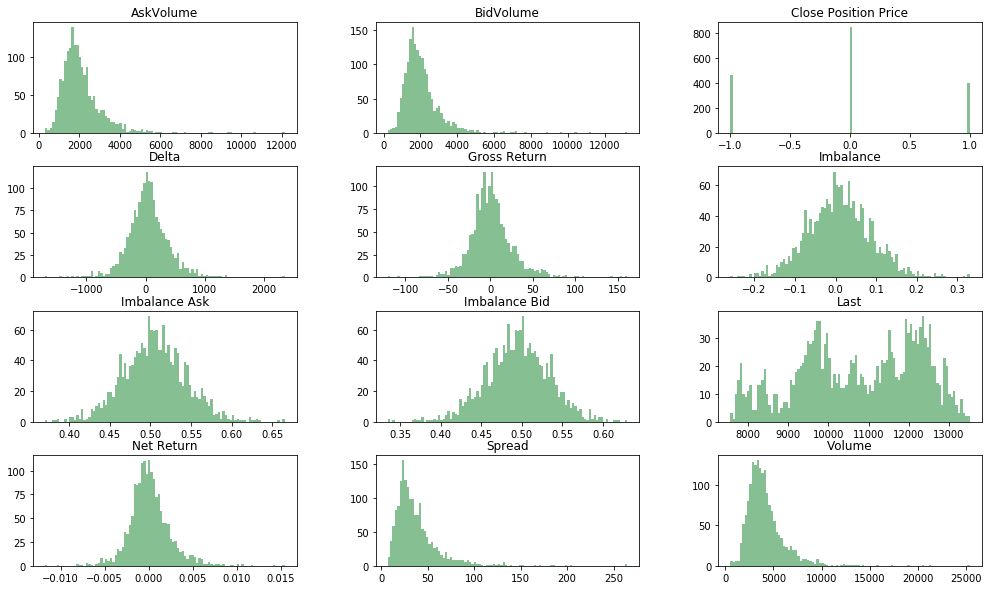

In [31]:
hist = data_preopen_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86bf91', zorder=2, rwidth=1.0)

_Ouverture effective du marché européen (matinée)_

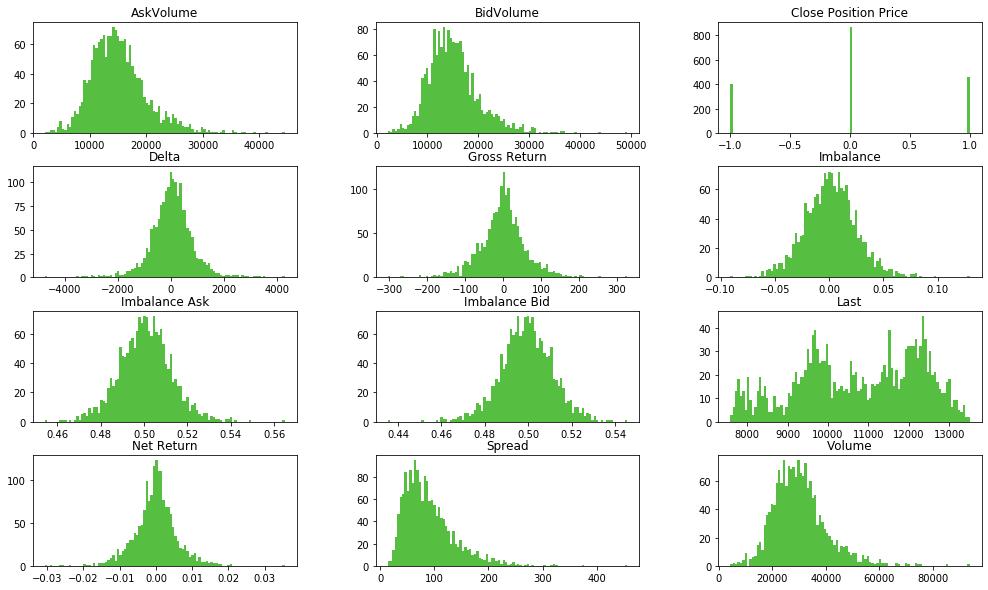

In [32]:
hist = data_morning_eu.hist(bins=100, figsize=(17,10), grid=False, color='#56bf41', zorder=2, rwidth=1.0)

_Après-midi dans le marché européen_

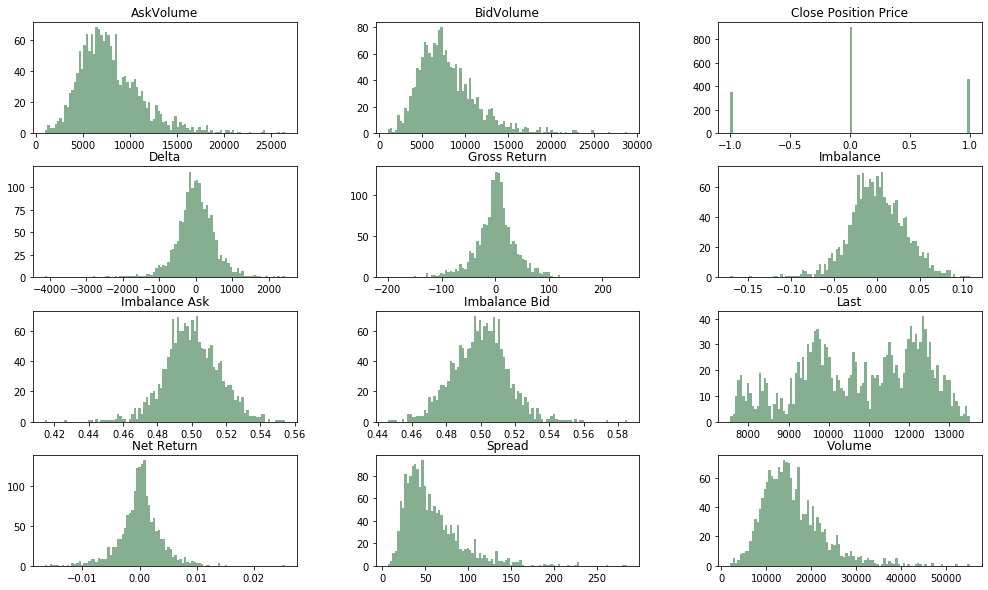

In [33]:
hist = data_afternoon_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86ae91', zorder=2, rwidth=1.0)

_Pré-ouverture du marché américain_

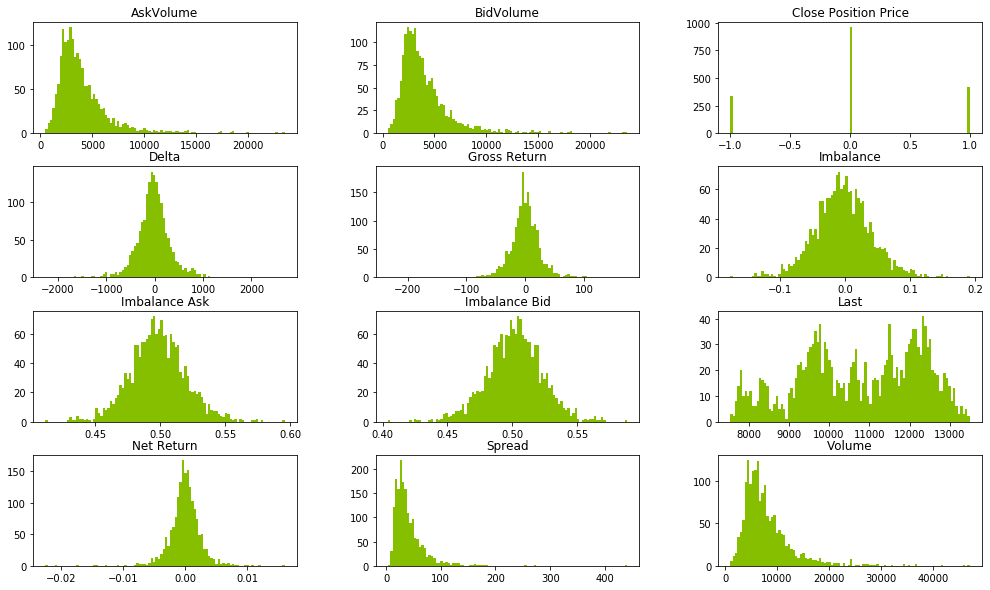

In [34]:
hist = data_preopen_us.hist(bins=100, figsize=(17,10), grid=False, color='#86bf00', zorder=2, rwidth=1.0)

_Pré-fermeture du marché européen (Ouverture effective du marché européen (matinée))_

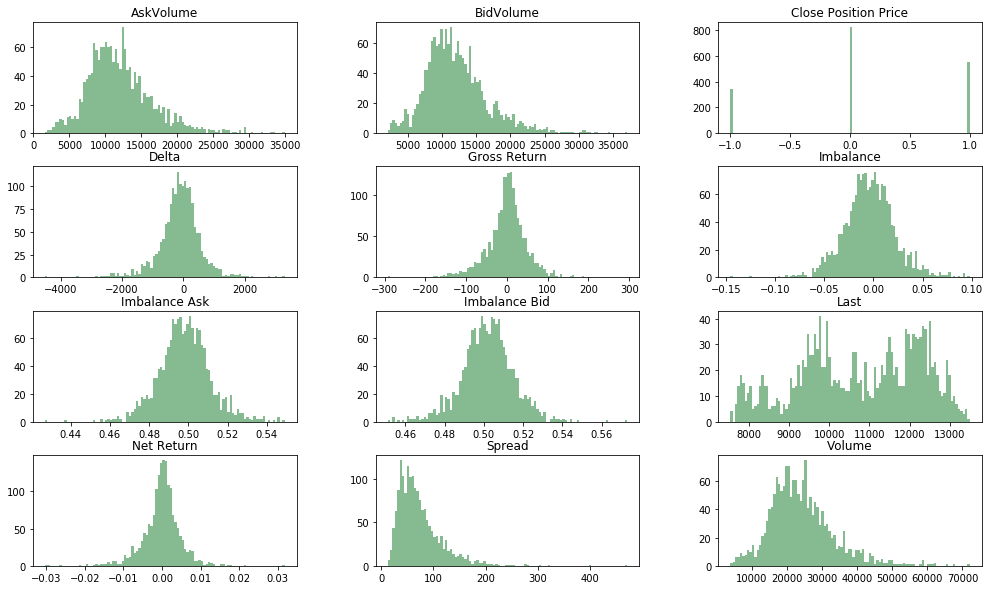

In [35]:
hist = data_close_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86ba91', zorder=2, rwidth=1.0)

_Pré-fermeture du marché européen_

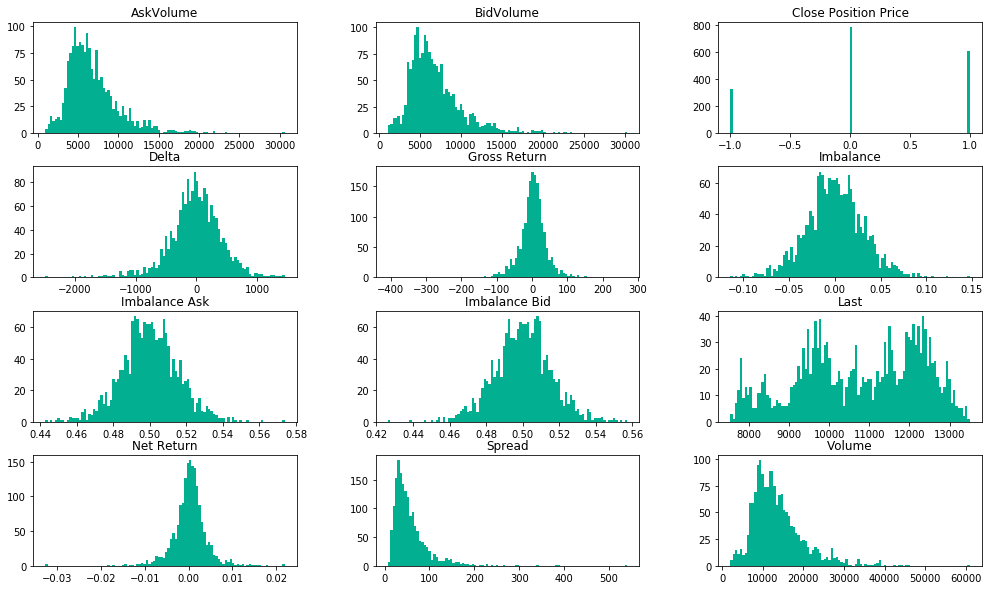

In [36]:
hist = data_close_us.hist(bins=100, figsize=(17,10), grid=False, color='#03af91', zorder=2, rwidth=1.0)

### _Histogram of Last relative to High and Low._

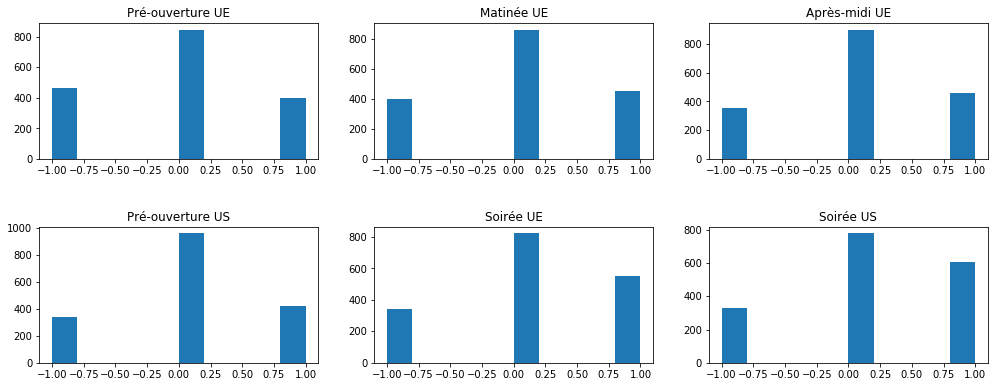

In [37]:
plt.figure(1, figsize=(17,10))
plt.subplot(3, 3, 1)
x = "Close Position Price"
plt.title('Pré-ouverture UE')
plt.hist(data_preopen_eu[x])

plt.subplot(3, 3,2)
plt.title('Matinée UE')
plt.hist(data_morning_eu[x])

plt.subplot(3, 3, 3)
plt.title('Après-midi UE')
plt.hist(data_afternoon_eu[x])

plt.subplot(3, 3,4)
plt.title('Pré-ouverture US')
plt.hist(data_preopen_us[x])

plt.subplot(3, 3, 5)
plt.title('Soirée UE')
plt.hist(data_close_eu[x])

plt.subplot(3, 3,6)
plt.title('Soirée US')
plt.hist(data_close_us[x])

plt.subplots_adjust(hspace=0.5)
plt.show()

In [38]:
data_close_us.columns

Index(['Last', 'Volume', 'BidVolume', 'AskVolume', 'Spread', 'Delta',
       'Net Return', 'Gross Return', 'Imbalance Bid', 'Imbalance Ask',
       'Imbalance', 'Close Position Price'],
      dtype='object')

<h3><center><font color=red>  Conclusion partielle 5 </font></center></h3>
<br/>
<font color=black>
Cette partie permet de visualiser les histogrammes de nos seize (16) variables.
<br/>
On pouvait s'y attendre, comme le laisse savoir la théorie que les returns ressemblent à une gaussienne.
<br/>
Le delta et les imbalances ressemblent également à des gaussiennes.
<br/>
La plupart de composantes efforts (ask volume, bid volume, volume et Nombre de trades), semblent avoir des fonctions de répartitions proches de loi de Khi-deux.
<br/>
Les points précédents sont plutôt à but informatif. Les histogrammes les plus intéressants sont ceux qui décrivent la position relative du Last en fonction du High et du Low: <br/>
En dehors des périodes de fermeture, le prix de fermeture est plutôt régulièrment espacée par rapport au high et au low. Mais lorsqu'on se rapproche de la fermeture des marchés européene et américains, Le prix de fermeture est beaucoup plus proche du High que du low.
<br/>
On peut donc s'attendre, entre 17h31 et 22h03, que les prix de fermetures soient très proches du High.
</font>
<hr/>

<h3><center id="categorie"><font color=darkblue> Catégories </font></center></h3>

Nous pouvons maintenant créer des catégories d'observations par rapport au zscore calculé précédemment pour le volume et le delta. En effet, le zscore permet mesurer la deviation d'un variable par rapport a sa moyenne mobile (est-ce une observation extrême en contraste avec les précédentes?). Nous commencons d'abord par voir leur distribution pour bien séparer les catégories: 

### _Création de variables_

In [39]:
data = pd.read_csv("DAX_STOXX/2019-10-16_DAX_1mn_BarData.txt", delimiter=',', skipinitialspace=True,
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)

data['Spread'] = data['High'] - data['Low'] 
data['Delta'] = data['AskVolume'] - data['BidVolume']
data['ZScoreDelta'] = (data['Delta']-data['Delta'].rolling(window=14).mean())/data['Delta'].rolling(window=14).std()
data['ZScoreVolume'] = (data['Volume']-data['Volume'].rolling(window=14).mean())/data['Volume'].rolling(window=14).std()
data['return'] = data['Last'] - data['Open'] 
data=data[15:]
data.head()

,Date,Time,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume,Spread,Delta,ZScoreDelta,ZScoreVolume,return
15,2013/1/4,08:15:00,7824.0,7824.0,7823.5,7824.0,11,8,4,7,0.5,3,0.571153,-0.886332,0.0
16,2013/1/4,08:16:00,7824.5,7825.5,7823.0,7823.0,66,27,40,26,2.5,-14,0.150931,-0.150149,-1.5
17,2013/1/4,08:17:00,7823.0,7826.5,7823.0,7826.5,32,16,2,30,3.5,28,1.173481,-0.631023,3.5
18,2013/1/4,08:18:00,7826.5,7826.5,7824.5,7824.5,23,10,17,6,2.0,-11,0.173808,-0.773923,-2.0
19,2013/1/4,08:19:00,7825.5,7827.5,7825.5,7827.0,59,19,11,48,2.0,37,1.233607,-0.271002,1.5


### _Fusionner les dates et les heures, puis convertir en DateTime_

In [40]:
data['Datetime'] = pd.to_datetime(data['Date'] + ' '+ data['Time'])

data = data.set_index(pd.DatetimeIndex(data['Datetime']))
data = data.drop('Time', axis=1)
data = data.drop('Datetime', axis=1)

data['Day']= data.index.day_name()

### _La nouvelle structure de données_

In [41]:
data['ZScoreDelta'].describe()

count    1.501353e+06
mean     2.778085e-04
std      9.788046e-01
min     -3.471839e+00
25%     -5.635445e-01
50%     -1.322770e-03
75%      5.625117e-01
max      3.471242e+00
Name: ZScoreDelta, dtype: float64

### _Comparer les variables a differentes tranches horaires_

Text(0.5, 1.0, 'Distribution du ZScoreDelta')

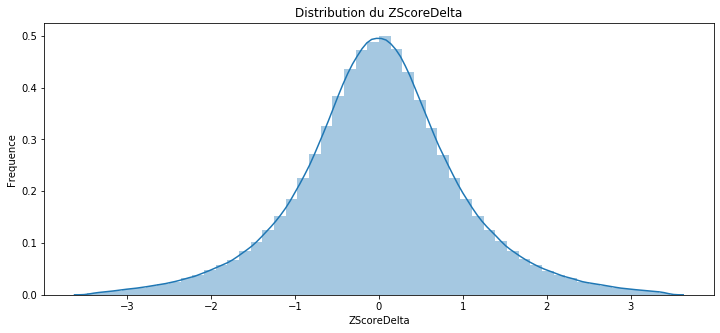

In [42]:
plt.figure(figsize = (12,5))
sns.distplot(data['ZScoreDelta'])
plt.xlabel('ZScoreDelta')
plt.ylabel('Frequence')
plt.title('Distribution du ZScoreDelta')

In [43]:
data['ZScoreVolume'].describe()

count    1.501353e+06
mean    -1.254441e-02
std      1.018367e+00
min     -2.908273e+00
25%     -7.286127e-01
50%     -2.805914e-01
75%      4.712732e-01
max      3.474396e+00
Name: ZScoreVolume, dtype: float64

Text(0.5, 1.0, 'Distribution du ZScoreVolume')

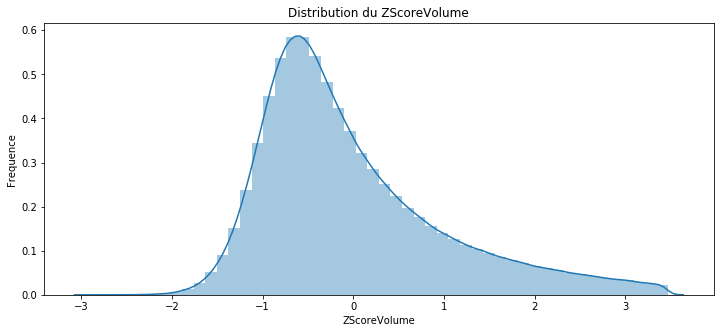

In [44]:
plt.figure(figsize = (12,5))
sns.distplot(data['ZScoreVolume'])
plt.xlabel('ZScoreVolume')
plt.ylabel('Frequence')
plt.title('Distribution du ZScoreVolume')

Cette section est dédiée à trouver des leviers sur le marché en utilisant le Zscore sur la différence de volume entre la demande et l'offre. Le Zscore est un outil statistique qui peut résumer le comportement du marché lors d'une fenêtre de temps précédente. L'étude des relations entre l'évolution du Zscore sur le delta et la différence de points peut être utile pour d'autres applications.

Tout d'abord, nous devons garder à l'esprit que l'interprétation la plus simple possible du Zscore est qu'un Zscore positif se traduit par une valeur du delta supérieure à la moyenne des 20 observations précédentes, tandis qu'une valeur négative se traduit par un delta inférieur à la moyenne. Plus la valeur absolue d'un Zscore est élevée, plus le delta associé à ce Zscore est une valeur aberrante par rapport à l'échantillon dans lequel il est calculé (fenêtre de temps).
On les catégorise en différentes modalités VH=Very High,H=High ,M=Medium ,L=Low ,VL= Very Low.  

In [45]:
data.loc[(data['ZScoreDelta']>=-0.385) & (data['ZScoreDelta']<=0.385), 'CategoryDelta'] = 'M'
data.loc[((data['ZScoreDelta']>=0.385) & (data['ZScoreDelta']<1.07)), 'CategoryDelta'] = 'H'
data.loc[((data['ZScoreDelta']>=1.07)), 'CategoryDelta'] = 'VH'
data.loc[((data['ZScoreDelta']<=-0.385) & (data['ZScoreDelta']>=-1.07)), 'CategoryDelta'] = 'L'
data.loc[((data['ZScoreDelta']<=-1.07)), 'CategoryDelta'] = 'VL' 

In [46]:
data.loc[(data['ZScoreVolume']>=-0.65) & (data['ZScoreVolume']<=0.25), 'CategoryVolume'] = 'M'
data.loc[((data['ZScoreVolume']>=0.25) & (data['ZScoreVolume']<1.5)), 'CategoryVolume'] = 'H'
data.loc[((data['ZScoreVolume']>=1.5)), 'CategoryVolume'] = 'VH'
data.loc[((data['ZScoreVolume']<=-0.65) & (data['ZScoreVolume']>=-1.1)), 'CategoryVolume'] = 'L'
data.loc[((data['ZScoreVolume']<=-1.1)), 'CategoryVolume'] = 'VL' 

In [47]:
data.tail()

,Date,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume,Spread,Delta,ZScoreDelta,ZScoreVolume,return,Day,CategoryDelta,CategoryVolume
Datetime,,,,,,,,,,,,,,,,,
2019-10-16 21:56:00,2019/10/16,12654.0,12654.0,12652.0,12653.0,23,12,17,6,2.0,-11,-0.789864,-0.723777,-1.0,Wednesday,L,L
2019-10-16 21:57:00,2019/10/16,12653.5,12655.0,12652.0,12655.0,31,20,16,15,3.0,-1,-0.049247,-0.449451,1.5,Wednesday,M,M
2019-10-16 21:58:00,2019/10/16,12656.0,12656.0,12654.0,12655.5,13,6,10,3,2.0,-7,-0.675233,-1.208495,-0.5,Wednesday,L,VL
2019-10-16 21:59:00,2019/10/16,12655.5,12656.5,12654.0,12655.0,83,52,46,37,2.5,-9,-0.872103,1.786469,-0.5,Wednesday,L,VH
2019-10-16 22:03:00,2019/10/16,12651.0,12651.0,12651.0,12651.0,26,1,26,0,0.0,-26,-1.874842,-0.622611,0.0,Wednesday,VL,M


### _Afficher l'histogramme des categories_

Une fois qu'on a cree les différentes modalités. Nous allons nous intersser aux modalités extremales VH et VL pour le volume et le delta: 

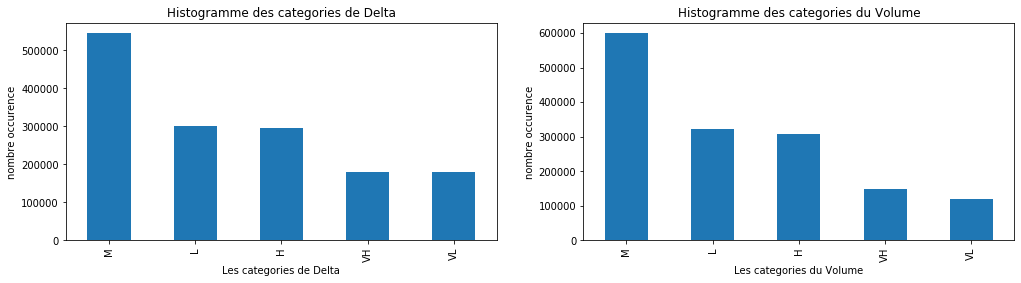

In [48]:
plt.figure(1, figsize=(17,12))
plt.subplot(2, 2, 1)
data['CategoryDelta'].value_counts().plot(kind='bar')
plt.xlabel('Les categories de Delta')
plt.ylabel('nombre occurence')
plt.title('Histogramme des categories de Delta')

plt.subplot(2, 2,2)
data['CategoryVolume'].value_counts().plot(kind='bar')
plt.xlabel('Les categories du Volume')
plt.ylabel('nombre occurence')
plt.title('Histogramme des categories du Volume')

plt.subplots_adjust(hspace=1)
plt.show()

### _Histogramme des jours en fonction de la categorie VH et VL_

On va voir dans cette partie la répartition de ces modalités sur les jours

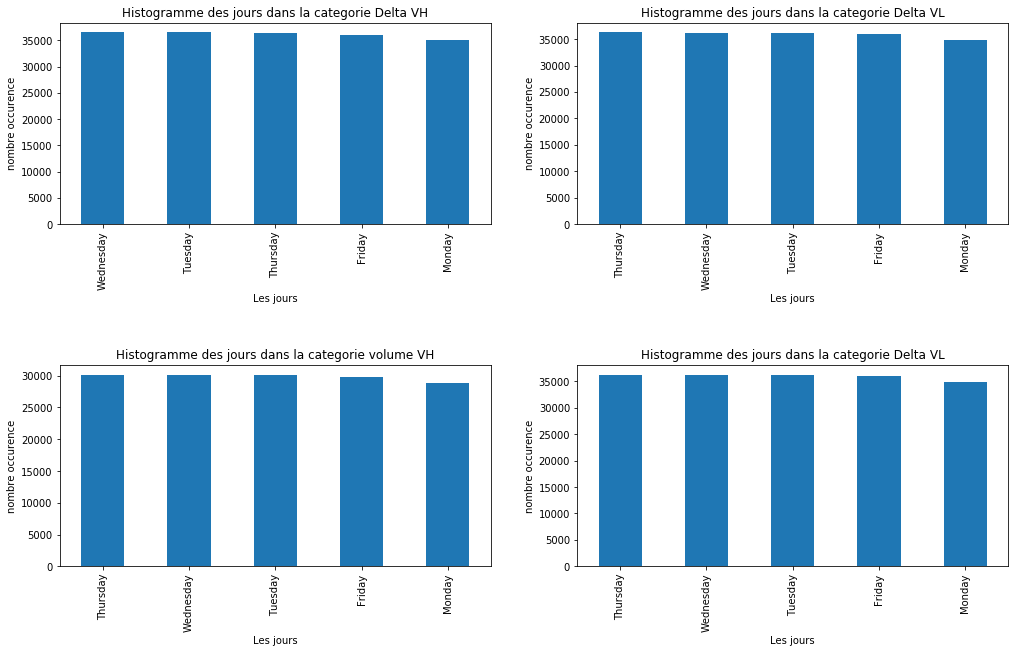

In [49]:
plt.figure(1, figsize=(17,10))

plt.subplot(2, 2, 1)
data[data['CategoryDelta']=='VH']['Day'].value_counts().plot(kind='bar')
plt.xlabel('Les jours')
plt.ylabel('nombre occurence')
plt.title('Histogramme des jours dans la categorie Delta VH')

plt.subplot(2, 2,2)
data[data['CategoryDelta']=='VL']['Day'].value_counts().plot(kind='bar')
plt.xlabel('Les jours')
plt.ylabel('nombre occurence')
plt.title('Histogramme des jours dans la categorie Delta VL')

plt.subplot(2, 2, 3)
data[data['CategoryVolume']=='VH']['Day'].value_counts().plot(kind='bar')
plt.xlabel('Les jours')
plt.ylabel('nombre occurence')
plt.title('Histogramme des jours dans la categorie volume VH')

plt.subplot(2, 2,4)
data[data['CategoryDelta']=='VL']['Day'].value_counts().plot(kind='bar')
plt.xlabel('Les jours')
plt.ylabel('nombre occurence')
plt.title('Histogramme des jours dans la categorie Delta VL')

plt.subplots_adjust(hspace=0.7)
plt.show()

<h3><center><font color=red>  Conclusion partielle 6 </font></center></h3>
<br/>
<font color=black>
La première chose qu'on remarque à travers ces graphiques c'est le lundi. C'est clairement le jour qui affiche le moins d'événements extrêmes. Ensuite, pour les autres jours le nombre d'événements extrêmes par jour est très proche avec une legère avance pour le jeudi.    
<br/>
    Pour mieux cerner les specificites de chaque jour, on va afficher separement les variables en fonction des jours:
</font>
<hr/>

<h3><center id="histogramme"><font color=darkblue> Spread, Return, Delta, Volume en fonction des jours  </font></center></h3>

### _spread en fonction des jours_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000180125F6BC8>,
      dtype=object)

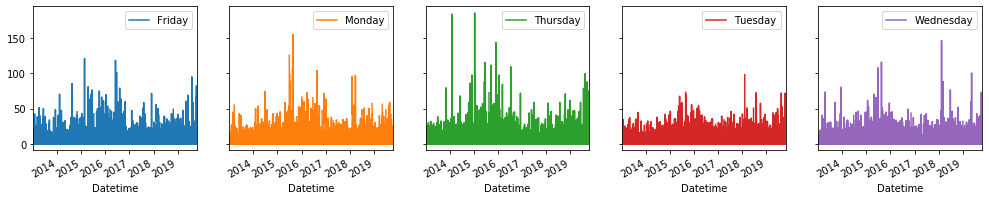

In [50]:
pd.pivot_table(data.loc[data['Day'] != 2006], values = "Spread", 
               columns = "Day", index = "Datetime").plot(subplots = True, figsize=(17, 10), layout=(3, 5), sharey=True)

### _Return en fonction des jours_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018012C91088>,
      dtype=object)

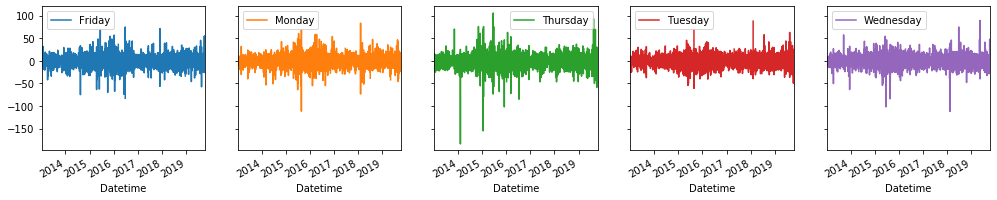

In [51]:
pd.pivot_table(data.loc[data['Day'] != 2006], values = "return", 
               columns = "Day", index = "Datetime").plot(subplots = True, figsize=(17, 10), layout=(3, 5), sharey=True)

### _Delta en fonction des jours_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018047C36508>,
      dtype=object)

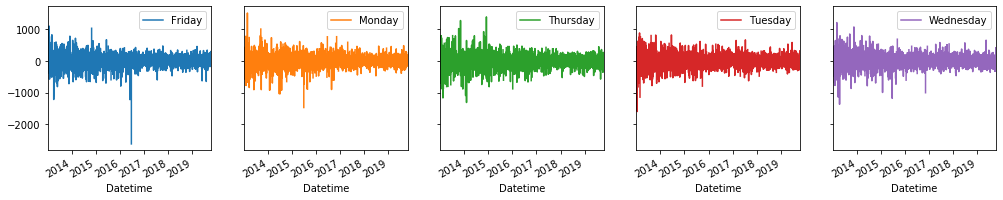

In [52]:
pd.pivot_table(data.loc[data['Day'] != 2006], values = "Delta", 
               columns = "Day", index = "Datetime").plot(subplots = True, figsize=(17, 10), layout=(3, 5), sharey=True)

### _Volume en fonction des jours_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018039492848>,
      dtype=object)

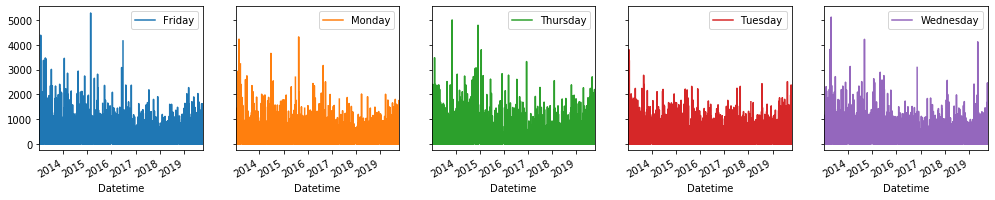

In [53]:
pd.pivot_table(data.loc[data['Day'] != 2006], values = "Volume", 
               columns = "Day", index = "Datetime").plot(subplots = True, figsize=(17, 10), layout=(3, 5), sharey=True)

On constate que le mardi est le jour le plus clame de la semaine. En effet, ces courbes sont plutot serrées avec une tendance claire. Par contre, le jeudi est le jour qui affiche le plus de variance dans ces courbes et parait donc comme le jour le plus interessant et qui donne le plus d'opportunités à saisir ceci est en patie expliqué par le fait qu'il affiche le nombre le plus elevé de VH et VL.

<h3><center id="jeudi"><font color=darkblue> La journée du Jeudi  </font></center></h3>

In [54]:
Thursday=data[data['Day']=='Thursday']

In [55]:
Thursday_preopen_eu=Thursday.between_time('8:00:00','8:59:00')
Thursday_morning_eu=Thursday.between_time('09:00:00', '11:59:00')
Thursday_afternoon_eu=Thursday.between_time('12:00:00', '14:29:00')
Thursday_preopen_us=Thursday.between_time('14:30:00', '15:29:00')
Thursday_close_eu=Thursday.between_time('15:30:00', '17:29:00')
Thursday_close_us=Thursday.between_time('17:30:00', '22:03:00')

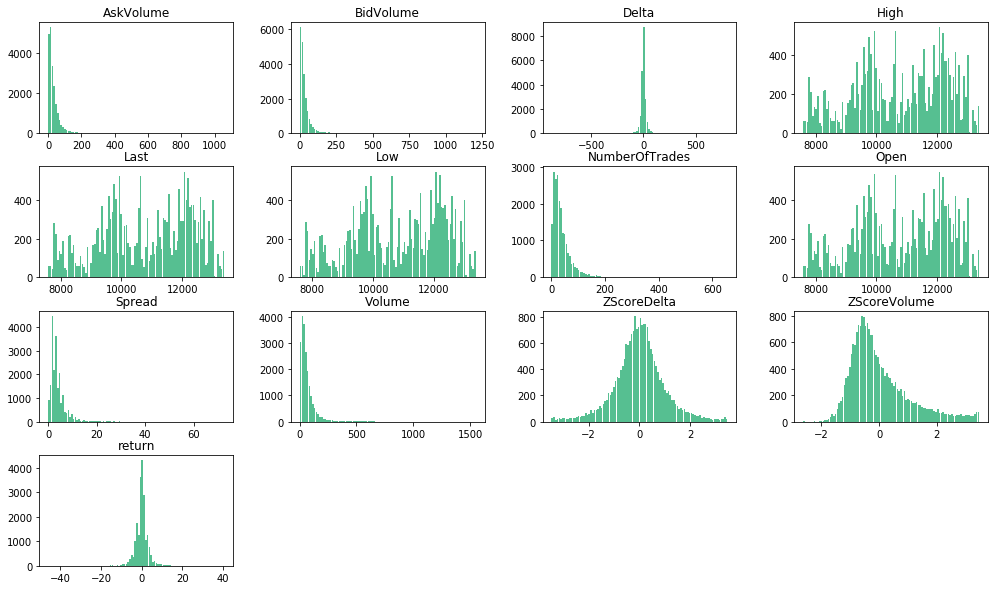

In [56]:
hist = Thursday_preopen_eu.hist(bins=100, figsize=(17,10), grid=False, color='#56bf91', zorder=2, rwidth=0.9)

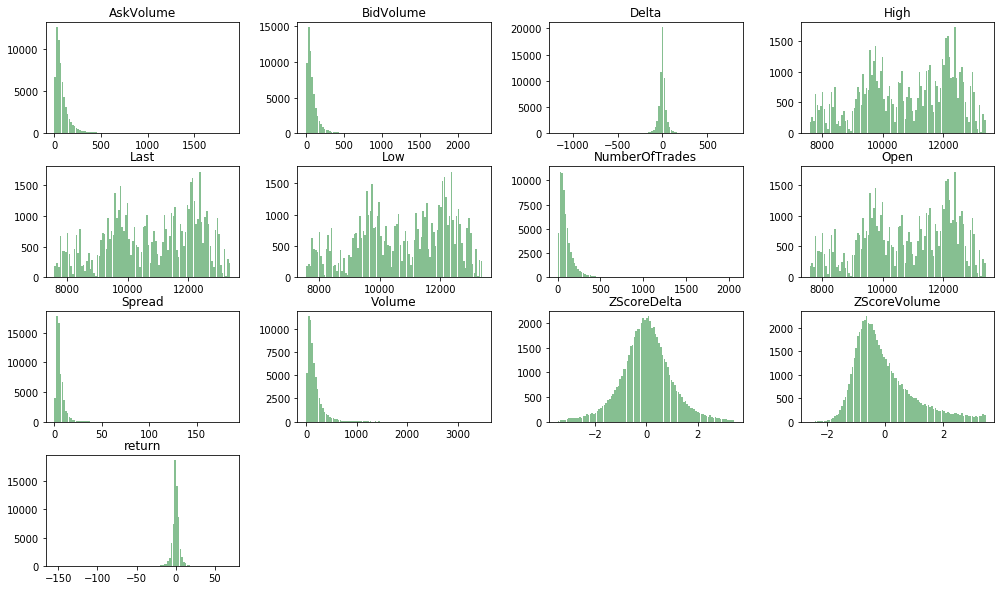

In [57]:
hist = Thursday_morning_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86bf91', zorder=2, rwidth=0.9)

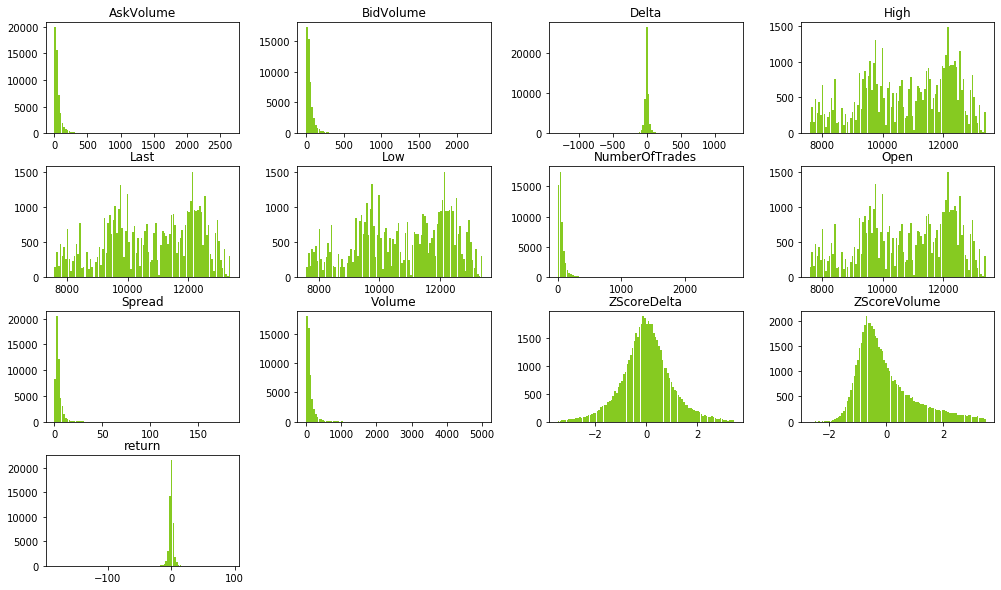

In [58]:
hist = Thursday_afternoon_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86ca21', zorder=2, rwidth=0.9)

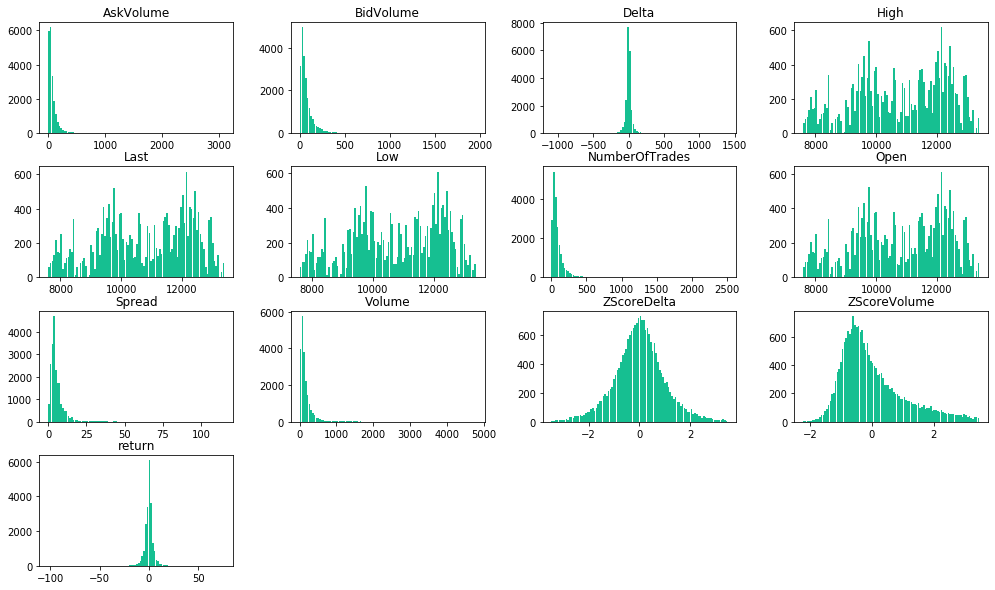

In [59]:
hist = Thursday_preopen_us.hist(bins=100, figsize=(17,10), grid=False, color='#16bf91', zorder=2, rwidth=0.9)

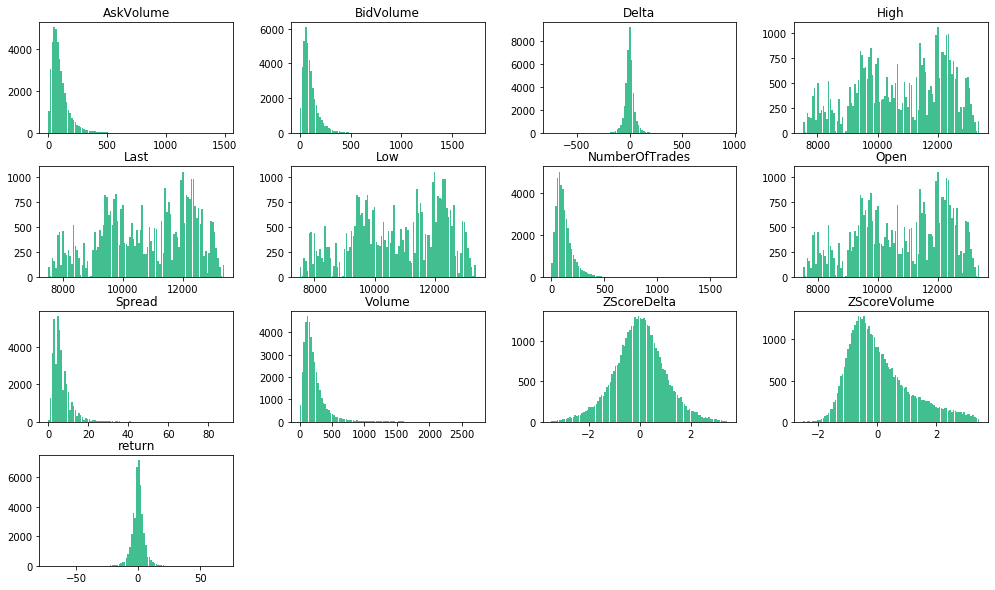

In [60]:
hist = Thursday_close_eu.hist(bins=100, figsize=(17,10), grid=False, color='#42bf91', zorder=2, rwidth=0.9)

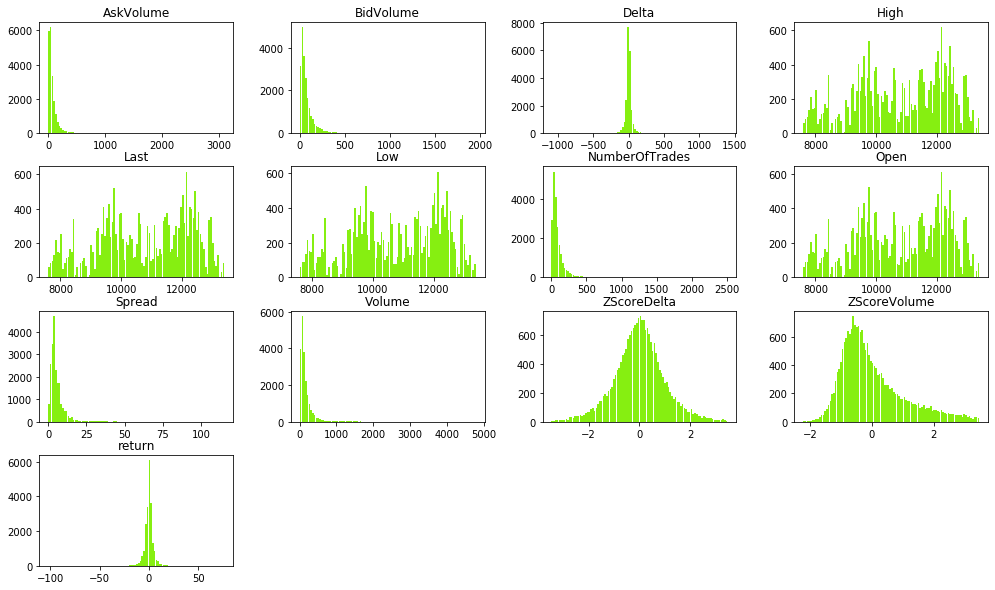

In [61]:
hist = Thursday_preopen_us.hist(bins=100, figsize=(17,10), grid=False, color='#86ef11', zorder=2, rwidth=0.9)

In [62]:
Thursday_afternoon_eu.max()

Date              2019/9/5
Open                 13386
High                 13388
Low                  13385
Last                 13386
Volume                5003
NumberOfTrades        2769
BidVolume             2339
AskVolume             2664
Spread                 184
Delta                 1285
ZScoreDelta        3.43166
ZScoreVolume        3.4721
return                93.5
Day               Thursday
CategoryDelta           VL
CategoryVolume          VL
dtype: object

In [63]:
Thursday_afternoon_eu[Thursday_afternoon_eu['return']==93.5]

,Date,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume,Spread,Delta,ZScoreDelta,ZScoreVolume,return,Day,CategoryDelta,CategoryVolume
Datetime,,,,,,,,,,,,,,,,,
2019-08-15 13:29:00,2019/8/15,11324.5,11424.0,11324.5,11418.0,1644,1194,669,975,99.5,306,3.346409,3.403691,93.5,Thursday,VH,VH


<h3><center><font color=red>  Conclusion partielle 7 </font></center></h3>
<br/>
<font color=black>
En divisant la journée du jeudi en plusieurs tranches horaires nous voyons que afternoon_eu et dans une moindre dimension morning_eu sont les tranches qui présentent les pics les plus elevés pour les différentes variables. On imagine donc que le jeudi de 9h à 14h30 est la période la plus nerveuse de la semaine statistiquement parlant.
</font>
<hr/>

<h3><center id="mardi"><font color=darkblue> La journée du Mardi  </font></center></h3>

In [64]:
Tuesday=data[data['Day']=='Tuesday']

In [65]:
Tuesday_preopen_eu=Tuesday.between_time('8:00:00','8:59:00')
Tuesday_morning_eu=Tuesday.between_time('09:00:00', '11:59:00')
Tuesday_afternoon_eu=Tuesday.between_time('12:00:00', '14:29:00')
Tuesday_preopen_us=Tuesday.between_time('14:30:00', '15:29:00')
Tuesday_close_eu=Tuesday.between_time('15:30:00', '17:29:00')
Tuesday_close_us=Tuesday.between_time('17:30:00', '22:03:00')

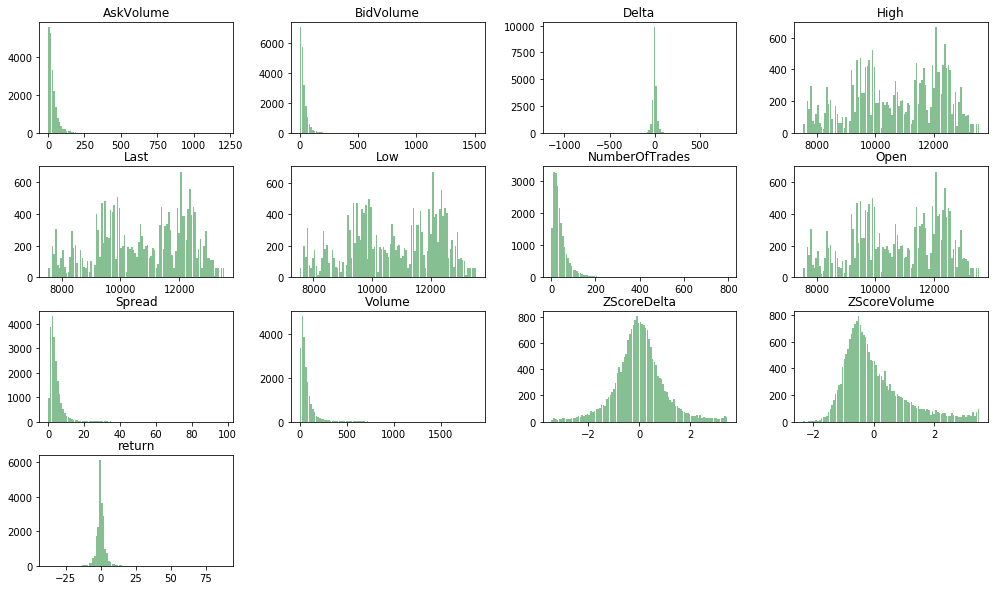

In [66]:
hist = Tuesday_preopen_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86bf91', zorder=2, rwidth=0.9)

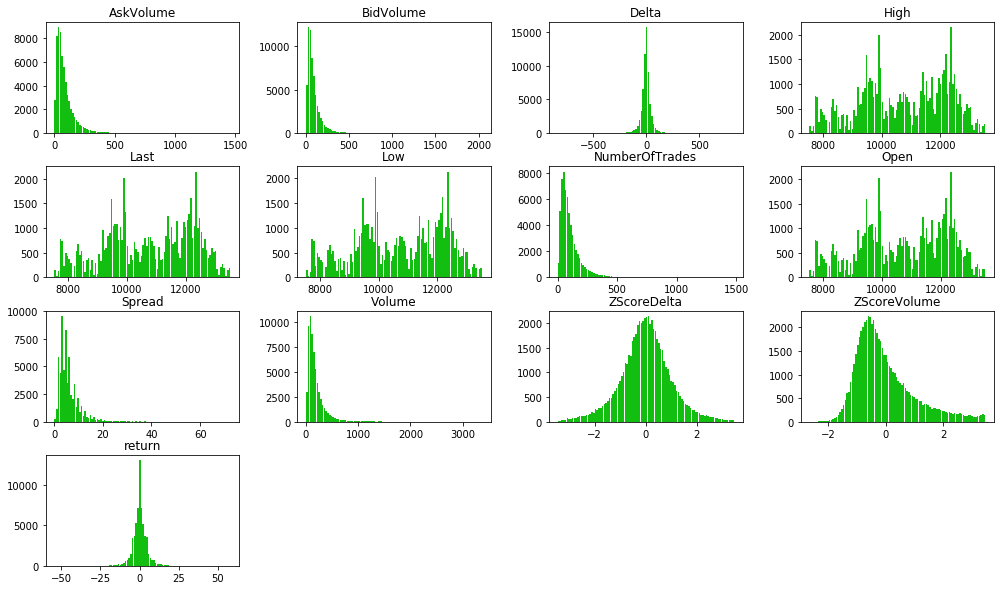

In [67]:
hist = Tuesday_morning_eu.hist(bins=100, figsize=(17,10), grid=False, color='#12bf11', zorder=2, rwidth=0.9)

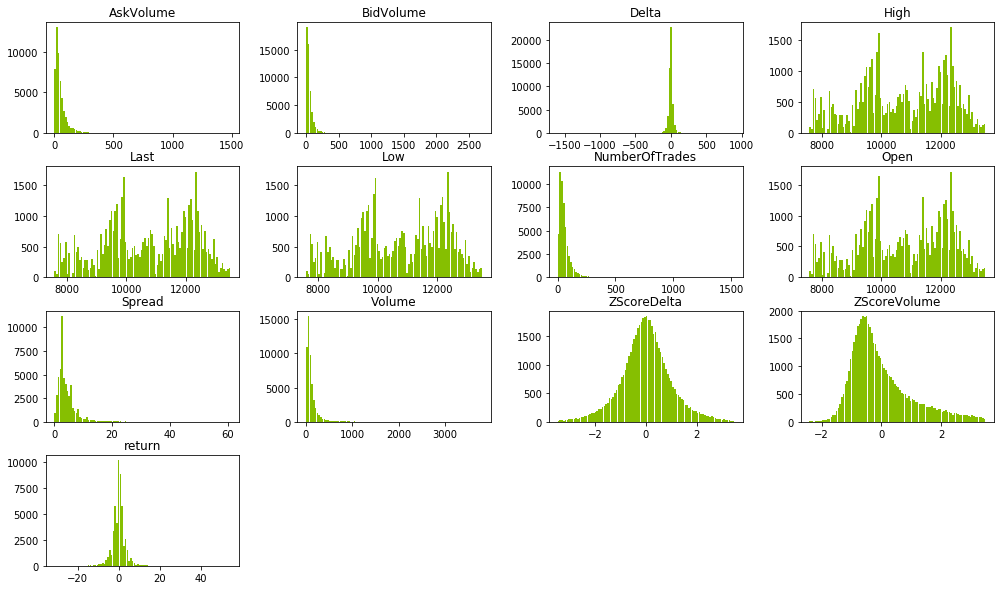

In [68]:
hist = Tuesday_afternoon_eu.hist(bins=100, figsize=(17,10), grid=False, color='#86bf01', zorder=2, rwidth=0.9)

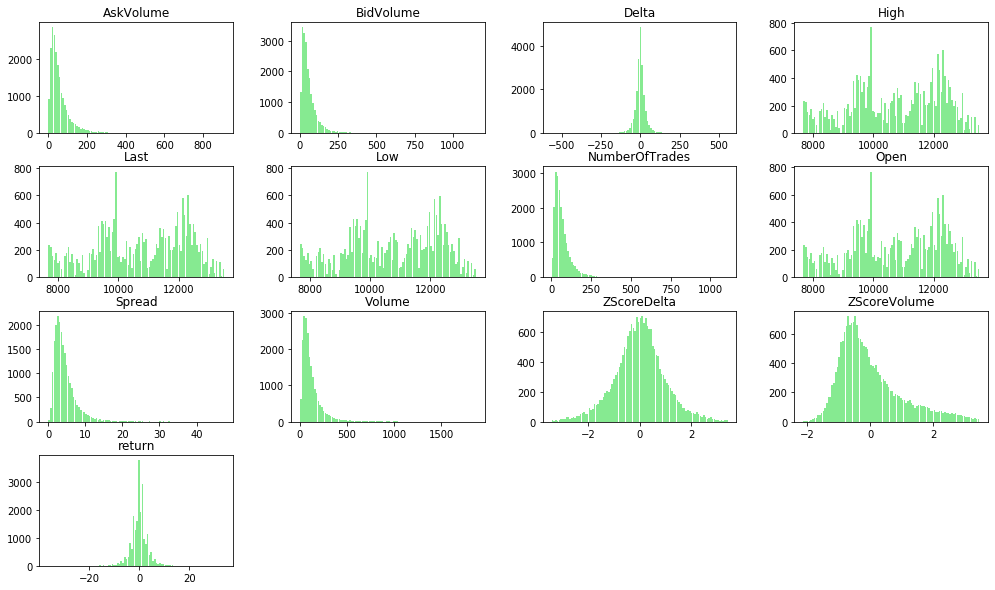

In [69]:
hist = Tuesday_preopen_us.hist(bins=100, figsize=(17,10), grid=False, color='#86ea91', zorder=2, rwidth=0.9)

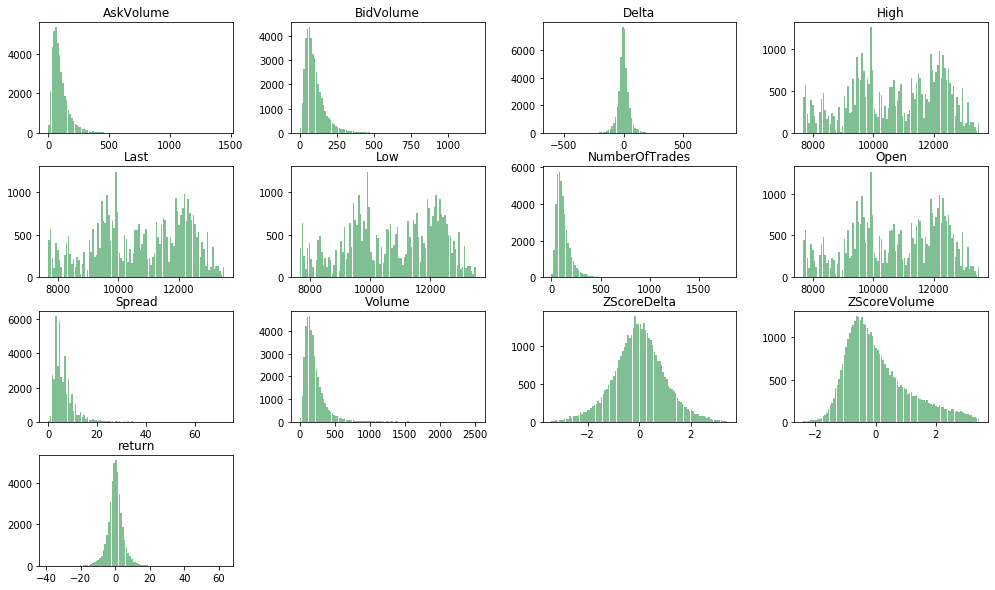

In [70]:
hist = Tuesday_close_eu.hist(bins=100, figsize=(17,10), grid=False, color='#80bf91', zorder=2, rwidth=0.9)

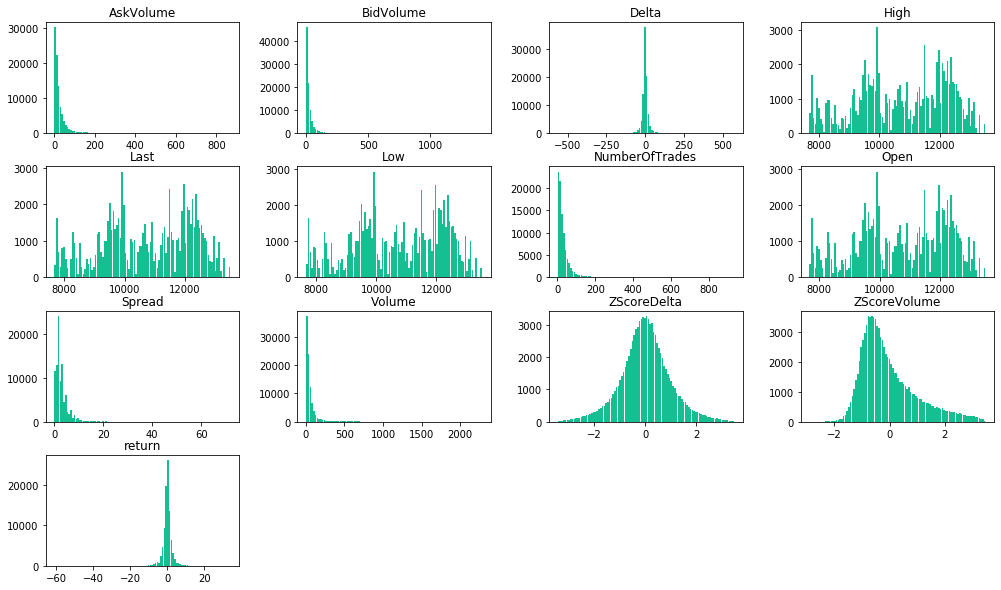

In [71]:
hist = Tuesday_close_us.hist(bins=100, figsize=(17,10), grid=False, color='#16bf91', zorder=2, rwidth=0.9)

<h3><center><font color=red>  Conclusion partielle 8 </font></center></h3>
<br/>
<font color=black>
On constate que les courbes des tranches horaires du mardi confirme que mardi est bien une journée calme. Ceci se voit à travers les distributions des returns et des deltas et des spreads. En effet, il y a des pics moins importants que le jeudi et surtout leur courbe est plus serrée et donc une variance plus petite ce qui montre que le mardi affiche bien moins d'événements extrêmes.
</font>
<hr/>

<h3><center><font color=red>  Conclusion de la partie Analyse Statistique </font></center></h3>
<font color=black>
Cette partie avait pour but non seulement de comprendre les données qu'on devait manipuler, mais également de trouver d'utiliser l'inférence statistique pour trouver des éléments pouvant aider le trader dans son travail quotidien. Les grandes conclusions qu'on peut tirer sont les suivantes (voir les conclusions partielles pour plus de détails) :
    <ul>
    <li>La moyenne des returns est la plus élevée en soirée US (entre 17h31 et 22h03 heure de Paris), dans le même temps l'écart-type des prix est moyenne. Durant cette période, il est donc intéressant de prendre des positions ou alors de laisser courir ses positions courantes.</li>
    <li>Il y a une presque une relation linéaire entre le volume (composante prix) et le spread (composante résultat). Si les volumes augmentent, on s'attend à ce que le spread augmente également. Cela ne permet pas facilement d'en déduire des décisions d'investissements. </li>
    <li>La corrélation linéaire entre le volume et le spread varie entre 0.69 et 0.78 selon les périodes de la journée. Ce qui confirme le point précédent.</li>
    <li>En dehors des périodes de fermeture, le prix de fermeture est plutôt régulièrment espacée par rapport au high et au low. Mais lorsqu'on se rapproche de la fermeture des marchés européene et américains, Le prix de fermeture est beaucoup plus proche du High que du low. Le trader peut donc utiliser le fait que, dès 17h31, le Last sera souvent très proche du High.</li>
        <li>On voit clairement que Zscoredelta suit une loi normale ce qui veut dire que delta n'est pas une variable qui permet de déterminer des évènements extrêmes. ZscoreVolume est quant à lui incliné vers les valeurs positives ceci est intuitif puisque les volumes ne prennent que des valeurs positives. </li>
        <li>On constate que le mardi est le jour le plus clame de la semaine, tandis que le jeudi est le plus agité. </li>
        <li> On imagine donc que le jeudi de 9h à 14h30 est la période la plus nerveuse de la semaine statistiquement parlant.</li>
        <li>Il y a le Mardi des pics moins importants que le jeudi et surtout leur courbe est plus serrée et donc une variance plus petite ce qui montre que le mardi affiche bien moins d'événements extrêmes.</li>
    </ul>
</font>
<hr/>

<h2><center id="partie1"><font color=darkblue><u> Partie 2 - Prédiction des prix (voire des volumes) futurs </u></font></center></h2>

Après toute la première qui consistait en l'analyse statistique des données de trades, cette partie consistait à prédire l'évolution future du prix, ou pour le dire de manière réaliste, trouver une stratégie de prise de position dans le future en connaissance du passé, tout en tenant compte de la relation effort (volume) et résultat (prix/return) qui est l'objectif de tout ce projet.
Ce travail se fait en deux principales étapes :
- Prédiction de la direction future des returns : il s'agit là d'attribuer le signe +1 aux returns positions et -1 aux returns négatifs, puis de faire tourner un algorithme de classification en utilisant comme variable explicative les variables passées, et comme variable expliquée la direction future.
- Prédiction de l'évolution future du prix : le prix est une série temporelle. De nombreuses séries temporelles sont prédictibles, cela reste difficile à faire pour les cours boursiers car ce sont des séries temporelles qui suivent des marches aléatoires. Les algorithmes de plus en plus performant de deep learning peuvent donner des résulats intéressants. Nous explorons ici principalement les modèles ARMA puis Long short-term memory (LSTM).

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


<h3><center id="preparation"><font color=darkblue> Préparation des données </font></center></h3>

### _Téléchargement des données_

In [2]:
data = pd.read_csv("DAX_STOXX/2019-10-16_DAX_1mn_BarData.txt", delimiter=',', skipinitialspace=True,
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)

In [3]:
data.shape

(1501368, 10)

### _Fusionner les dates et les heures, puis convertir en DateTime_

In [4]:
data = data.set_index(pd.DatetimeIndex(data['Date']))
data['Datetime'] = pd.to_datetime(data['Date'] + ' '+ data['Time'])
data = data.drop('Date', axis=1)
data = data.drop('Time', axis=1)

### _Sélection des données à utiliser pour les algorithmes (dans le but de réduire les temps d'apprentissage)_

In [5]:
#data = data.loc['2019-10-01']
data = data[data.shape[0]-5000:data.shape[0]]
data = data.set_index(pd.DatetimeIndex(data['Datetime']))
data = data.drop('Datetime', axis=1)

In [6]:
data.shape

(5000, 8)

In [7]:
data.head()

,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume
Datetime,,,,,,,,
2019-10-10 15:09:00,12063.0000,12063.5000,12061.0000,12062.0000,37,25,13,24
2019-10-10 15:10:00,12062.0000,12069.5000,12062.0000,12065.0000,342,226,142,200
2019-10-10 15:11:00,12065.5000,12066.0000,12064.5000,12066.0000,373,176,170,203
2019-10-10 15:12:00,12064.0000,12067.5000,12064.0000,12067.5000,40,26,10,30
2019-10-10 15:13:00,12068.0000,12068.0000,12065.5000,12066.0000,54,32,37,17


### _Création de variables_

In [8]:
def eval_pos(x, y, z):
    v = (x-y)/(x-z)
    for i in range(v.shape[0]):
        if v[i] <= 0.25:
            v[i] = -1
        elif v[i] > 0.75:
            v[i] = 1
        else:
            v[i] = 0
    return v

In [9]:
def complete_columns(data_):
    data_['Spread'] = data_['High'] - data_['Low'] 
    data_['Delta'] = data_['AskVolume'] - data_['BidVolume']
    data_['Net Return'] = (data_['Last'] - data_['Open']) / data_['Open']
    data_['Gross Return'] = (data_['Last'] - data_['Open'])
    data_['Imbalance Bid'] = (data_['BidVolume'] ) / (data_['Volume'] )
    data_['Imbalance Ask'] = (data_['AskVolume'] ) / (data_['Volume'] )
    data_['Imbalance'] = data_['Imbalance Ask'] - data_['Imbalance Bid']
    data_['Close Position Price'] = eval_pos(data_['Low'], data_['Last'], data_['High'])
    data_["Direction"] = np.sign(data_['Net Return'])
    data_["Next Direction"] = np.append(data_["Direction"][1:data_.shape[0]].values, 0)
    data_["NextCPP"] = np.append(data_["Close Position Price"][1:data_.shape[0]].values, 0)
    data_ = data_.drop('High', axis=1)
    data_ = data_.drop('Low', axis=1)
    data_ = data_.drop('Open', axis=1)
    data_ = data_.drop('Direction', axis=1)
    data_ = data_.drop('Close Position Price', axis=1)
    return data_

In [10]:
data = complete_columns(data)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
col = ['Last', 'Volume', 'NumberOfTrades', 'BidVolume',
       'AskVolume', 'Spread', 'Delta', 'Net Return', 'Gross Return',
       'Imbalance Bid', 'Imbalance Ask', 'Imbalance']#, 'Open', 'High', 'Low']
data[col] = scaler.fit_transform(data[col])

### _La nouvelle structure de données_

In [12]:
df_ = data.copy()
data.tail()

,Last,Volume,NumberOfTrades,BidVolume,AskVolume,Spread,Delta,Net Return,Gross Return,Imbalance Bid,Imbalance Ask,Imbalance,Next Direction,NextCPP
Datetime,,,,,,,,,,,,,,
2019-10-16 21:56:00,0.9411,0.0122,0.0086,0.0183,0.0056,0.0244,0.3405,0.3287,0.3313,0.7391,0.2609,0.2609,1.0000,1.0000
2019-10-16 21:57:00,0.9443,0.0167,0.0148,0.0172,0.0141,0.0366,0.3599,0.3585,0.3614,0.5161,0.4839,0.4839,-1.0000,0.0000
2019-10-16 21:58:00,0.9451,0.0067,0.0039,0.0108,0.0028,0.0244,0.3482,0.3346,0.3373,0.7692,0.2308,0.2308,-1.0000,0.0000
2019-10-16 21:59:00,0.9443,0.0456,0.0398,0.0495,0.0348,0.0305,0.3444,0.3346,0.3373,0.5542,0.4458,0.4458,0.0000,0.0000
2019-10-16 22:03:00,0.9379,0.0139,0.0000,0.0280,0.0000,0.0000,0.3113,0.3406,0.3434,1.0000,0.0000,0.0000,0.0000,0.0000


<hr/>
<h3><center id="direction"><font color=darkblue> Prédiction de la direction (+1/0/-1) à l'instant t+1 en fonction des variables à l'instant t </font></center></h3>

L'idée dans cette partie est de prédire le signe du return à l'instant t+1 :
- +1 si les returns sont positifs;
- 0 si le prix reste constant;
- -1 si les returns sont négatifs);

Sachant les variables explicatives  de l'instant t qui sont : 
- 'Last', 
- 'Volume', 
- 'NumberOfTrades', 
- 'BidVolume',
- 'AskVolume', 
- 'Spread', 
- 'Delta', 
- 'Net Return', 
- 'Gross Return',
- 'Imbalance Bid', 
- 'Imbalance Ask', 
- 'Imbalance'

On fait donc simplement tourner un algorithme de classification sur nos données. <br/>
Il existe de nombreux algorithmes de classification : _Rocchio classification, Bagging, Boosting, Forêts aléatoires, Arbres de décision, k plus proches voisins (kNN), Régression logistique, Support Vector Machine (SVM)_<br/>
Nous avons expérimenté et optimisé <b>kNN</b> et <b>Randoms forests</b>. Après avoir affiché le nuage de points colorés en fonction du signe de return.

### _Sélection des données, de l'ensemble d'apprentissage et de test_

In [13]:
df_['Next Direction'] = df_['Next Direction'].astype("int64")
X_train, X_test = df_[:4500], df_[4501:]

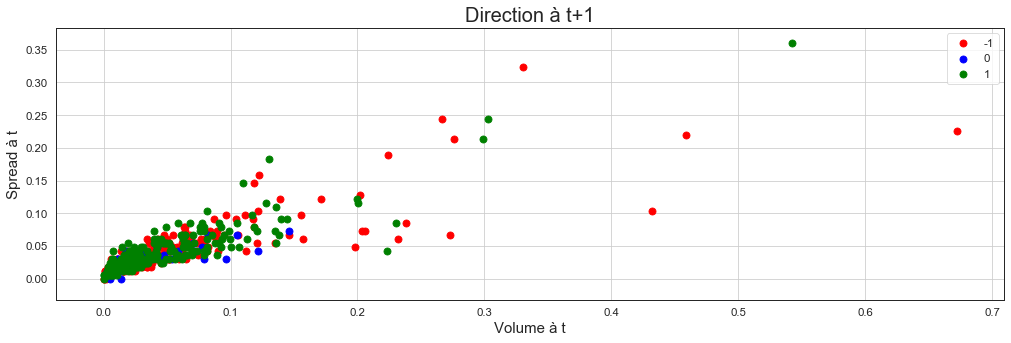

In [85]:
fig = plt.figure(figsize = (17,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Volume à t', fontsize = 15)
ax.set_ylabel('Spread à t', fontsize = 15)
ax.set_title('Direction à t+1', fontsize = 20)
targets = [-1,0, 1]
colors = ['r', 'b', 'g', 'y', 'm']
for target, color in zip(targets,colors):
    indicesToKeep = X_test['Next Direction'] == target
    ax.scatter(X_test.loc[indicesToKeep, 'Volume']
               , X_test.loc[indicesToKeep, 'Spread']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

<h3><center><font color=red>  Conclusion partielle </font></center></h3>
<br/>
<font color=black>
Le nuage de points 2D des données avecc en abscisse le volume et en ordonnée le spread (choisi d'après les analyses précédentes), puis colorés en fonction du signe du return nous montrent que les données semblent ne pas être séparables. En effet, pour utiliser un algorithme de classification sur les données, il faut déjà que les données soient séparables, sinon ça ne vaut pas la peine. <br/>
    
Néanmoins, on ne peut pas encore conclure car, si des données ne sont pas séparables en 2D, elles peuvent l'être dans une dimension supérieure. Il est naturellement plus difficile de le montrer. Nous allons donc exécuter nos algorithmes de classification.
</font>
<hr/>

<h3><center id="knn"><font color=darkblue> Algorithme des K Plus proches voisins (kNN) </font></center></h3>

L'algorithme des k plus proches voisins (k-NN) est une méthode non paramétrique utilisée pour la classification et la régression. Dans les deux cas, il s'agit de classer l'entrée dans la catégorie à laquelle appartient les k plus proches voisins dans l'espace des caractéristiques identifiées par apprentissage. Le résultat dépend si l'algorithme est utilisé à des fins de classification ou de régression.

<br/>En classification k-NN, le résultat est une classe d'appartenance. Un objet d'entrée est classifié selon le résultat majoritaire des statistiques de classes d'appartenance de ses k plus proches voisins, (k est un nombre entier positif généralement petit). Si k = 1, alors l'objet est affecté à la classe d'appartenance de son proche voisin.

In [86]:
y = X_train["Next Direction"]
x = X_train[col]

### _Optimisation des hyperparamètres_

L'objectif est ici est d'optimiser les hyperparamètres de l'algorithme kNN afin de voir celui qui minimise l'erreur de classification de nos données (ça prend naturellement beaucoup de temps pour l'exécution... Plus il y a de données, plus ça prend du temps).

### _Ensemble des hyperparamètres_

In [87]:
k_range=list(range(1,31))
options=['uniform', 'distance']
metrics = ['braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine','dice', 
           'hamming', 'jaccard', 'kulsinski', 'minkowski', 
           'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'] 
param_grid = dict(n_neighbors=k_range, weights=options, metric=metrics)

### _Exécution..._

In [88]:
rfc=KNeighborsClassifier()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['braycurtis', 'canberra', 'chebyshev',
                                    'correlation', 'cosine', 'dice', 'hamming',
                                    'jaccard', 'kulsinski', 'minkowski',
                                    'rogerstanimoto', 'russellrao',
                                    'sokalmichener', 'sokalsneath',
                                    'sqeuclidean', 'yule'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 

### _Les paramètres optimaux_

In [89]:
CV_rfc.best_params_

{'metric': 'yule', 'n_neighbors': 2, 'weights': 'uniform'}

### _Exécution avec les paramètres optimaux_

In [90]:
neigh = KNeighborsClassifier(n_neighbors=2, metric='yule', weights="uniform")
neigh.fit(x, y)

y_pred=neigh.predict(X_test[col])

### _Erreur de classification_

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, X_test["Next Direction"]))

              precision    recall  f1-score   support

          -1       0.01      0.25      0.02         8
           0       0.00      0.00      0.00         1
           1       0.98      0.44      0.61       490

    accuracy                           0.44       499
   macro avg       0.33      0.23      0.21       499
weighted avg       0.96      0.44      0.60       499



In [92]:
from collections import Counter
d = Counter(y)
print('{} apparait {} fois'.format(1, d[1]), ' soit {}'.format(d[1]/len(X_train))) 
print('{} apparait {} fois'.format(0, d[0]), ' soit {}'.format(d[0]/len(X_train))) 
print('{} apparait {} fois'.format(-1, d[-1]), ' soit {}'.format(d[-1]/len(X_train))) 

1 apparait 1975 fois  soit 0.4388888888888889
0 apparait 679 fois  soit 0.15088888888888888
-1 apparait 1846 fois  soit 0.4102222222222222


<h3><center><font color=red>  Conclusion sur la classification UP/DOWN </font></center></h3>
<font color=black>
Notre kNN même après optimisation, donne un taux de bonne classification à peine égale à 0.33. Ce qui est très mauvais. En effet, même en classant aléatoirement (avec une loi de probabilité telle que $p(i = [-1, 0, 1]) = \frac{Nombre de -1 (ou 0 ou 1) de train}{Taille de train}$, on pouvait espérer plus).
</font>
<hr/>

<h3><center id="random"><font color=darkblue> Forêts aléatoires </font></center></h3>

L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

La base du calcul repose sur l'apprentissage par arbre de décision. La proposition de Breiman3 vise à corriger plusieurs inconvénients connus de la méthode initiale, comme la sensibilité des arbres uniques à l'ordre des prédicteurs, en calculant un ensemble de $B$ arbres partiellement indépendants.

Une présentation rapide de la proposition peut s'exprimer comme suit :

- Créer $B$ nouveaux ensembles d'apprentissage par un double processus d'échantillonnage :
    - sur les observations, en utilisant un tirage avec remise d'un nombre $N$ d'observations identique à celui des données d'origine (technique connue sous le nom de bootstrap),
    - et sur les $p$ prédicteurs, en n'en retenant qu'un échantillon de cardinal $m <\sqrt {p}$ (la limite n'est qu'indicative).
- Sur chaque échantillon, on entraîne un arbre de décision selon une des techniques connues, en limitant sa croissance par validation croisée.
- On stocke les $B$ prédictions de la variable d'intérêt pour chaque observation d'origine.
- La prédiction de la forêt aléatoire est alors un simple vote majoritaire (Ensemble learning).
- Le principal revers de cette méthode est que l'on perd l'aspect visuel des arbres de décision uniques.
Le but de cette partie est de créer une stratégie en se basant sur la prédiction de la tendance du Last (haussière ou baissière) réalisée grâce à l'algorithme des forêts d'arbres décisionnels. 

### _Affichage des paramètres_

In [93]:
clf = RandomForestClassifier(random_state = 5)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf)

Parameters currently in use:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


### _Configuration des paramètres_

In [94]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### _Création du modèle des Forêts aléatoires_

In [95]:
model = clf.fit(x, y)
y_pred, X_test["Next Direction"]

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1, 

### _Affichage de la performance de prédiction_ 

In [96]:
# Run the code to view the classification report metrics
report = classification_report(X_test["Next Direction"], model.predict(X_test[col]))
print(report)

              precision    recall  f1-score   support

          -1       0.45      0.62      0.52       217
           0       0.19      0.08      0.11        62
           1       0.47      0.37      0.42       220

    accuracy                           0.44       499
   macro avg       0.37      0.36      0.35       499
weighted avg       0.43      0.44      0.42       499



<h3><center><font color=red>  Conclusion sur les Forêts aléatoires </font></center></h3>
<font color=black>
On tire exactement le même résultat que dans l'algorithme précédent. On ne peut tirer aucune question intéressante avec la classification pour l'instant. 
</font>
<hr/>

<hr/>
<h3><center id="ar"><font color=darkblue> Prédiction de la courbe du prix à partir des autres variables : Par un modèle ARMA(p,q)</font></center></h3>

Un modèle autorégressif et moyenne-mobile d'ordres (p,q) (abrégé en ARMA(p,q)) est un processus temporel discret $(X_t, t \in N)$ vérifiant :
$X_{t}=\varepsilon _{t}+\sum _{i=1}^{p}\varphi _{i}X_{t-i}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}$
où les $\varphi _{i}$ et $\theta _{i}$ sont les paramètres du modèle et les εi les termes d'erreur.

Dans notre exemple, $X_t$ désignera le Volume à l'instant t.

#### Estimation du volume à l'instant t+1 sachant le volume au p (à déterminer) derniers instants en utilisant un modèle ARMA

In [16]:
X = data["Volume"]
X_train, X_test = X[:500], X[501:600]

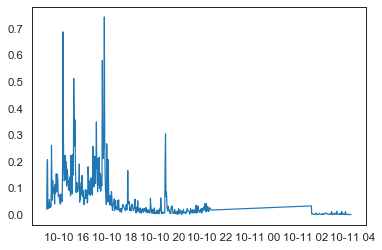

In [17]:
plt.plot(X_train)

### _Optimisation des hyperparamètres du modèle autorégressif pour la prédiction du volume_

In [18]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

### _Exécution_

In [19]:
series = X_train
# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
#evaluate_models(series, p_values, d_values, q_values)

### _Exécution avec les hyperparamètres_

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(X_train, order=(1, 0, 1)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  500
Model:                     ARMA(1, 1)   Log Likelihood                 700.405
Method:                       css-mle   S.D. of innovations              0.060
Date:                Mon, 13 Apr 2020   AIC                          -1392.810
Time:                        16:45:30   BIC                          -1375.952
Sample:                             0   HQIC                         -1386.195
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0543      0.016      3.377      0.001       0.023       0.086
ar.L1.Volume     0.9272      0.026     35.296      0.000       0.876       0.979
ma.L1.Volume    -0.5502      0.072     -7.63

### _Prédiction_

In [21]:
forecast = model.predict(len(X_train), len(X_train)+len(X_test))

### _Affichage des résultats_

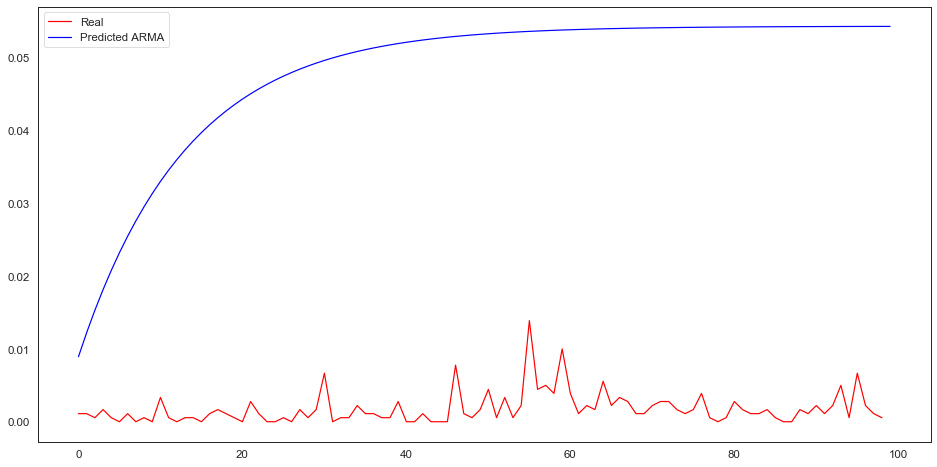

In [22]:
plt.figure(figsize=(16,8))
plt.plot(X_test.values, label="Real", color="Red")
plt.plot(forecast.values, label="Predicted ARMA", color="Blue")
plt.legend()

<h3><center><font color=red>  Conclusion sur le modèle autorégressif </font></center></h3>
<font color=black>
La série des volumes semble bien stationnaire (car bornée), donc il n'est pas con de vouloir appliqué un modèle autorégressif, même si c'est un modèle tout simple mais qui a fait ses preuves notamment dans la prédiction de l'inflation avant l'arrivée des forêts aléatoires.

Malheureusement, après de multiples exécutions, après l'optimisation des hyperparamètres, le résultat de la prédiction est très très loin du résultat attendu. Le résultat obtenu semble être la moyenne sur la période, le bruit n'est pas pris en compte on ne sait pour quelles raisons. Mais l'utilisation du modèle ARMA reste vraiment à explorer.
</font>
<hr/>

<h3><center id="lstm"><font color=darkblue> Prédiction de la courbe du prix à partir des autres variables : Par un modèle LSTM </font></center></h3>

### _Préparation des données pour le modèle LSTM_

In [23]:
df = df_.copy()
#df = df.drop('Time', axis=1)
df = df.drop('Open', axis=1)
df = df.drop('High', axis=1)
df = df.drop('Low', axis=1)
df = df.drop('Net Return', axis=1)
df = df.drop('Spread', axis=1)
df = df.drop('Gross Return', axis=1)
df = df.drop('Spread%', axis=1)
#df = df.drop('Close Position Price', axis=1)
dataset = df["Last"].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

KeyError: "['Open'] not found in axis"

### _Création d'une structure de données adaptée au LSTM_

In [104]:
def create_dataset(dataset, look_back=0):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])

    return np.array(X), np.array(Y)

In [105]:
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [106]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [107]:
X_test.shape

(989, 1, 10)

### _Création et apprentissage du LSTM_

In [108]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=20, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 3989 samples, validate on 989 samples
Epoch 1/200
3989/3989 [==============================] - 3s 779us/step - loss: 0.0817 - val_loss: 0.0386
Epoch 2/200
3989/3989 [==============================] - 1s 260us/step - loss: 0.0804 - val_loss: 0.0268
Epoch 3/200
3989/3989 [==============================] - 1s 219us/step - loss: 0.0780 - val_loss: 0.0334
Epoch 4/200
3989/3989 [==============================] - 1s 230us/step - loss: 0.0826 - val_loss: 0.0265
Epoch 5/200
3989/3989 [==============================] - 1s 264us/step - loss: 0.0793 - val_loss: 0.0332
Epoch 6/200
3989/3989 [==============================] - 1s 226us/step - loss: 0.0788 - val_loss: 0.0334
Epoch 7/200
3989/3989 [==============================] - 1s 221us/step - loss: 0.0780 - val_loss: 0.0294
Epoch 8/200
3989/3989 [==============================] - 1s 273us/step - loss: 0.0827 - val_loss: 0.0357
Epoch 9/200
3989/3989 [==============================] - 1s 241us/step - loss: 0.0801 - val_loss: 0.0325
Epoch 10

### _Calcul et affichage des erreurs d'apprentissage et de test du LSTM_

In [109]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.08511799411541404
Train Root Mean Squared Error: 0.09652590890732497
Test Mean Absolute Error: 0.17153286994166514
Test Root Mean Squared Error: 0.17225592333824497


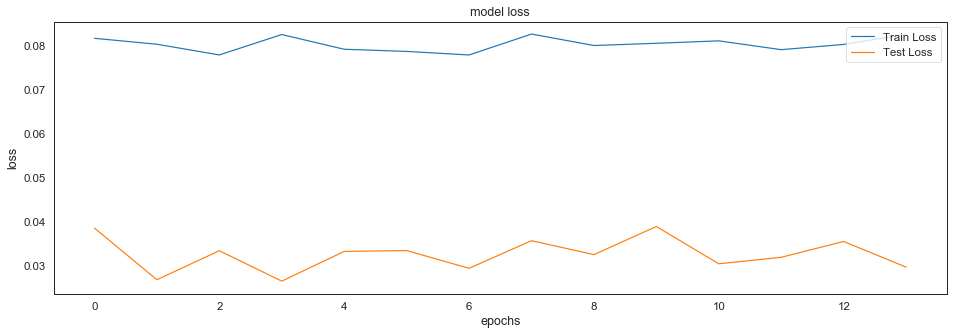

In [110]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

### _Résultat de la prédiction et comparaison acec les données de tes réelles_

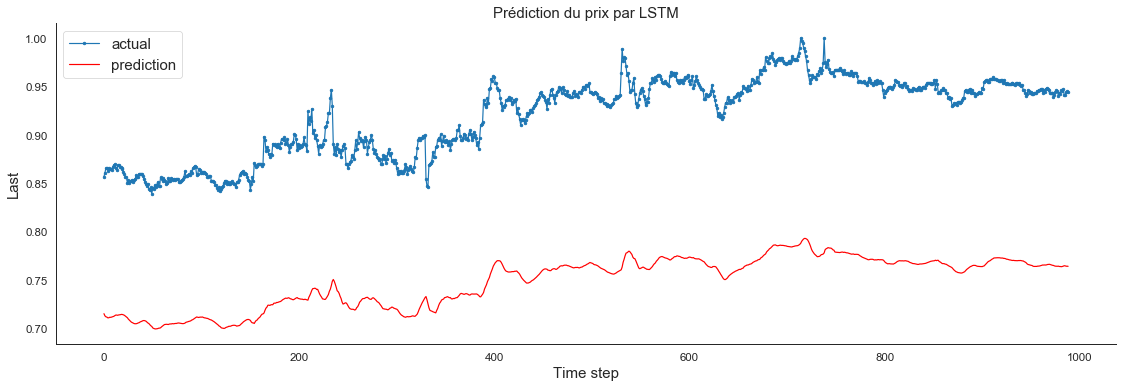

In [111]:
aa=[x for x in range(len(X_test))]
plt.figure(figsize=(16,5))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Prédiction du prix par LSTM', size=15)
plt.ylabel('Last', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

<h3><center><font color=red>  Conclusion sur le LSTM </font></center></h3>
<font color=black>

Le réseau LSTM affiche certes une mauvaise prédiction (écart de 150 points) mais suit la tendance globale du cours du DAX. Ce réseau de neurones peut servir à prévoir les tendances haussière et baissière et servir d'aide à la prise de position. 

</font>
<hr/>

<h3><center id="garch"><font color=darkblue> Par un modèle GARCH : Volume Filtered GARCH Model </font></center></h3>

Dans ce modèle,  les hypothèses principales sont les suivantes : 
    - Le log-volume des trades suit un modèle ARMA(p,q) dont les paramètres sont à déterminer.
    - Le returns est déterminé par une relation dont les paramètres dépendent du log-volume.

In this model, the return over the full trading day : <br/>
- $r_{t} = ln(\frac{p_t}{ p_{t−1}})$ where $p_t$ is price at t
- $v_t = log (\frac{V_t}{V_{t-1}}) $ where $V_t$ is volume at t
- $r_t = \mu + \sqrt{h_t}*\epsilon_t = \mu + \sqrt{\tau_t} \exp ({\frac{\gamma*u_t}{2}}) \epsilon_t$
- ${1 − \phi_1*L − ... − \phi_p * L^p }*v_t = \theta_0 + {1 + \theta_1*L + ... + \theta_q * L^q}*u_t$ with $u_t \sim N (0; \sigma_u^2)$
- $\begin{eqnarray*}
\begin{pmatrix}\epsilon_{t}\\
u_{t}
\end{pmatrix} & \sim & N\left[\left(\begin{array}{c}
0\\
0
\end{array}\right),\left(\begin{array}{ccc}
1 & \sigma_u\rho\\
\sigma_u\rho & \sigma_u^2\\
\end{array}\right)\right]\\
\end{eqnarray*}$ with $\rho = cov(\epsilon_t, u_t)$
- $\tau_t = \omega + \alpha_1 \frac{(r_{t−1} − \mu)2}{ g_{t−1}} + \beta_1*\tau_{t−1}$ with $\omega > 0; \alpha_1; \beta_1 ≥ 0$ and $\alpha_1 + \beta_1 < 1$

<h3><center><font color=red>  Conclusion de la partie Prédiction </font></center></h3>
<font color=black>
Dans la seconde partie de notre projet, nous voulions prédire comment se comporterait les prix futures en fonctions des variables précédents. Pour cela, nous avons utilsé deux principales approches : 
    <ul>
    <li>Classification du signe du return en t+1 sachant les variables en t : La visualisation nous a fait penser que nos données n'étaient pas séparables. Ce que a semblé nous confirmer les deux algorithmes de classification (Random Forests et k Nearest Neighbours) que nous avons exécutés par la suite, malgré que les paramètres ont été optimisés. On ne peut pas conclure car il existe de nombreux algorithmes de classication (cités plus haut) et ils dépendent souvent des données. L'idée par la suite serait donc de tester plusieurs algorithmes.</li>
    <li>Prédiction du prix ou du volume futur (vus comme une série temporelle) : 
        <ul><li>Sachant la relation linéaire entre le spread et le volume (trouvé dans la partie statistique), "prédire" le volume revient à "prédire" le spread. Malheureusement, les différents essais sur le modèle ARMA ne donnent pas de résultats concluants. Pourtant, les arguments théoriques laissent à penser que ça devrait être le cas. Il faut probablement revoir le code et/ou les bibliothèques utilisées</li>
            <li>Dans un second temps, directement sur le prix futur. LSTM donne un résultat très intéressant. La tendance des données prédites est exactement comme celle des données réelles. Pourtant, il y a un écart stable entre les deux courbes. Là aussi, il faut voir au niveau du code, notamment en optimisant les hyperparamètres du LSTM. Cela prendrait beaucoup de temps, mais on peut espérer des résultats intéressants.</li>
        </ul>
    </li>
    </ul>
</font>
<hr/>

<h2><center id="conclusion"><font color=darkblue><u> Conclusion </u></font></center></h2>
<font color=black>
A travers ce projet, nous avons pu analysé des données de marché par jour et par tranches horaires ce qui nous a permis de mettre en évidence de différences de comportement significatives qui permet d'améliorer la qualité des résultats de trading. A la lumière de ces résultats nous avons implémenté des algorithmes de machine learning de manière à pouvoir utiliser les biais présents sur les marchés, qui prédit les prix des actifs dans le futur et dans certains cas le coupler à une stratégie adaptée à cette méthode de trading. <br/><br/>
    De plus, ce projet nous a permis de :
    <lu>
    <li>Nous familiariser avec le vocabulaire des marchés financiers : bid, ask, spread, delta, imbalance, etc. et de bénéficier des connaissances d'un trader expérimenté tel Monsieur Laurent Abril. </li>
        <li>De piloter un projet de bout en bout en ayant plus ou moins la main libre sur les choix du langage de programmation, des modèles à implémenter, des échéances entre autres.</li>
        <li>D'analyser des données marchés et de tirer des décisions d'investissements utiles et réelles.</li>
        <li>De comprendre la différence qu'il y a entre une analyse théorique et une analyse sur les données réelles. Dans le sens où les modèles choisies et utilisées dans les papiers scientifiques ne collent pas toujours avec les données que l'on manipule. Il faut donc prendre du recul dans ces situations là et pas s'enfermer dans le modèle mais plutôt apprendre de ses données.</li>
        <li>D'avoir des prémisses de ce que c'est le métier d'ingénieur.</li>
    </ul>
</font>
<hr/>

<h4><center id="conclusion"><font color=darkblue>Le 12 Février 2020</font></center></h4>